In [213]:
import pandas as pd
import numpy as np
import reframed
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st
import scipy
import sys 
sys.path.append('../../../code/')
import leakage
import utils
from matplotlib.colors import LogNorm, Normalize

from matplotlib import cm, colors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import auc
from scipy.signal import find_peaks


In [214]:
folder = Path('../../../data/vila_2023/')



# Read in experimental data


In [215]:
targeted_fn = folder / 'Targeted_LCMS.csv'
dft = pd.read_csv(targeted_fn)
dft.rename(columns = {'Carbon_Source': 'Carbon source', 'Metabolite_Conc': 'Concentration'}, inplace=True)

In [216]:
exomet_carbon_sources = dft['Carbon source'].unique()

In [217]:
for s in dft.Strain.unique():
    sidx = (dft.Strain == s)&(dft.Concentration > 0)
    print(s, dft.loc[sidx, 'Carbon source'].unique(), dft.loc[sidx, 'Carbon source'].nunique())
    # print(dft.loc[sidx] )

Ecoli ['D-Glucose' 'L-Malate' 'D-Fructose' 'D-Galactose' 'D-Ribose'
 'L-Arabinose' 'Glycerol' 'Pyruvate'] 8
Enterobacter ['D-Glucose' 'L-Malate' 'D-Fructose' 'D-Galactose' 'D-Ribose'
 'L-Arabinose' 'Glycerol' 'Pyruvate'] 8
Pputida ['D-Glucose' 'L-Malate' 'Acetate' 'D-Fructose' 'Glycerol' 'Pyruvate'
 'Succinate' 'Fumarate'] 8
Pseudomonas ['D-Glucose' 'L-Malate' 'Acetate' 'D-Fructose' 'Glycerol' 'Pyruvate'
 'Succinate' 'Fumarate'] 8


In [218]:
# Growth data
growth_fn = folder / 'Targeted_LCMS_Growth_Curves.csv'
growth_df= pd.read_csv(growth_fn)

In [219]:
growth_df.replace('Psuedomonas', 'Pseudomonas', inplace=True)

# Estimate AUC
At 16 and 28 hours

In [220]:
max_od_dict = {}
for s in growth_df.Strain.unique():
    max_ctrl = growth_df.loc[(growth_df.Strain==s)&(growth_df['Carbon_Source']=='Ctrl'), 'OD'].max()
    max_od_dict[s] = max_ctrl

maxg = growth_df.groupby(['Carbon_Source', 'Strain']).agg({'OD':'max'})
maxg.sort_values(by='OD', ascending=True, inplace=True)
maxg.head(20)

cs_to_drop = []
for idx, od in maxg.iterrows():
    if od.max() < max_od_dict[idx[1]]*2:
    # if (od.max() < 0.04) or (idx[0]=='Ctrl'):
    # if (idx[0]=='Ctrl'):
        print(f'Drop: {idx}')
        cs_to_drop.append(idx)





Drop: ('Ctrl', 'Enterobacter')
Drop: ('Ctrl', 'Ecoli')
Drop: ('Acetate', 'Enterobacter')
Drop: ('Succinate', 'Enterobacter')
Drop: ('Fumarate', 'Enterobacter')
Drop: ('Ctrl', 'Pseudomonas')
Drop: ('L-Arabinose', 'Pseudomonas')
Drop: ('Acetate', 'Ecoli')
Drop: ('D-Galactose', 'Pseudomonas')
Drop: ('D-Ribose', 'Pseudomonas')
Drop: ('Ctrl', 'Pputida')
Drop: ('Succinate', 'Ecoli')
Drop: ('Fumarate', 'Ecoli')
Drop: ('D-Galactose', 'Pputida')
Drop: ('L-Arabinose', 'Pputida')


In [221]:
maxg

OD
Carbon_Source Strain              
Ctrl          Enterobacter  0.0378
              Ecoli         0.0386
Acetate       Enterobacter  0.0393
Succinate     Enterobacter  0.0409
Fumarate      Enterobacter  0.0411
Ctrl          Pseudomonas   0.0417
L-Arabinose   Pseudomonas   0.0435
Acetate       Ecoli         0.0438
D-Galactose   Pseudomonas   0.0465
D-Ribose      Pseudomonas   0.0466
Ctrl          Pputida       0.0490
Succinate     Ecoli         0.0537
Fumarate      Ecoli         0.0580
D-Galactose   Pputida       0.0591
L-Arabinose   Pputida       0.0621
L-Malate      Ecoli         0.0940
Pyruvate      Ecoli         0.1081
D-Ribose      Pputida       0.1818
Glycerol      Ecoli         0.1865
L-Arabinose   Ecoli         0.2404
D-Fructose    Ecoli         0.2408
D-Galactose   Ecoli         0.2510
Pyruvate      Enterobacter  0.3046
D-Fructose    Pputida       0.3244
Pyruvate      Pputida       0.3367
D-Fructose    Pseudomonas   0.3413
Glycerol      Pputida       0.3428
D-Glucose     Ecoli         0.3476
L-Arabinose   Enterobacter  0.3534
D-Ribose      Ecoli         0.3688
Succinate     Pseudomonas   0.4020
Fumarate      Pseudomonas   0.4039
D-Ribose      Enterobacter  0.4058
D-Glucose     Pputida       0.4172
D-Galactose   Enterobacter  0.4174
L-Malate      Pputida       0.4180
              Pseudomonas   0.4366
D-Fructose    Enterobacter  0.4452
L-Malate      Enterobacter  0.4527
Glycerol      Pseudomonas   0.4645
Acetate       Pputida       0.4789
Glycerol      Enterobacter  0.4946
Acetate       Pseudomonas   0.5079
D-Glucose     Pseudomonas   0.5141
Pyruvate      Pseudomonas   0.5158
D-Glucose     Enterobacter  0.5159
Succinate     Pputida       0.5305
Fumarate      Pputida       0.5470

## Find peak times

44 0.11
A02 27.33333333 0.78


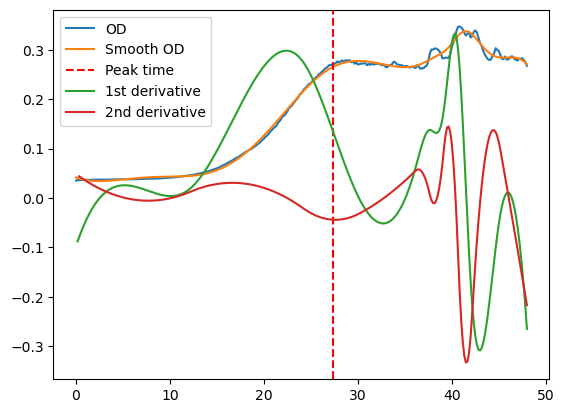

19 0.07
B02 12.5 0.63


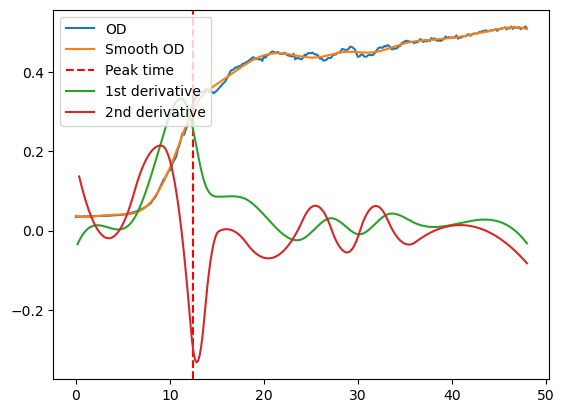

73 0.11
120 0.3
C02 23.66666667 0.82


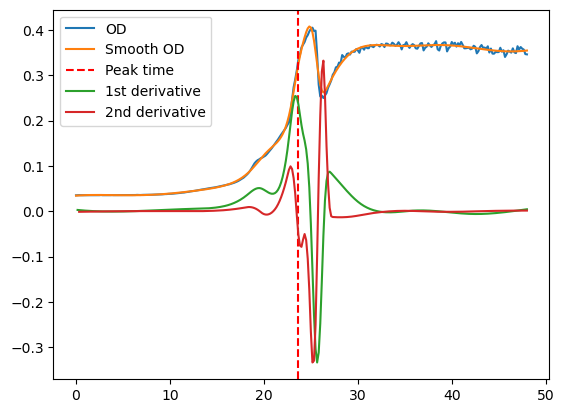

98 0.42
153 0.59
D02 42.5 1.0


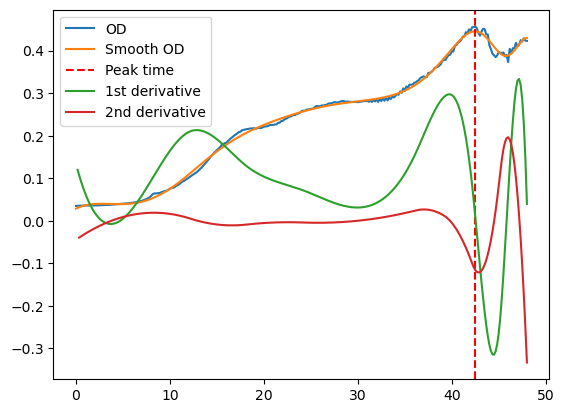

A03 34.66666667 0.99


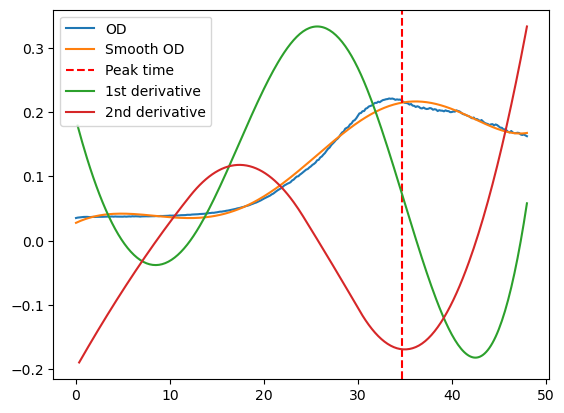

36 0.09
80 0.52
B03 14.83333333 0.64


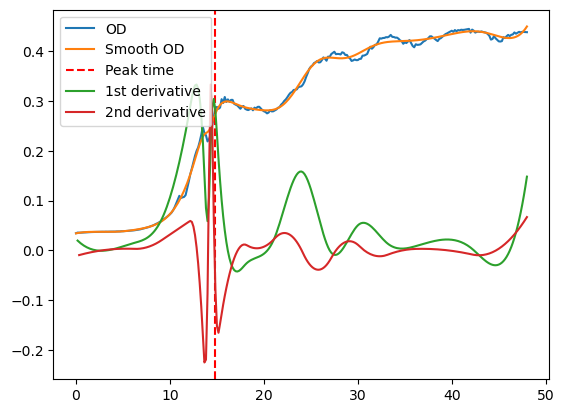

67 0.13
C03 37.5 1.0


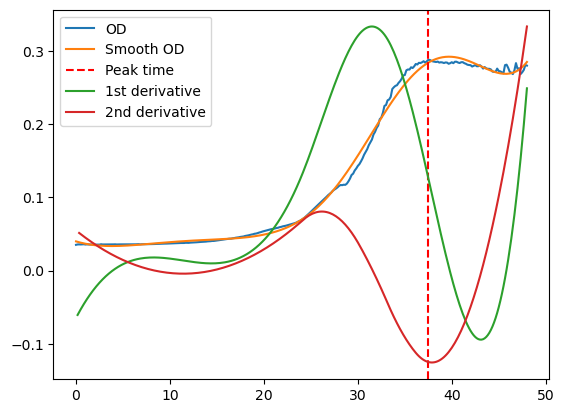

D03 48.0 0.91


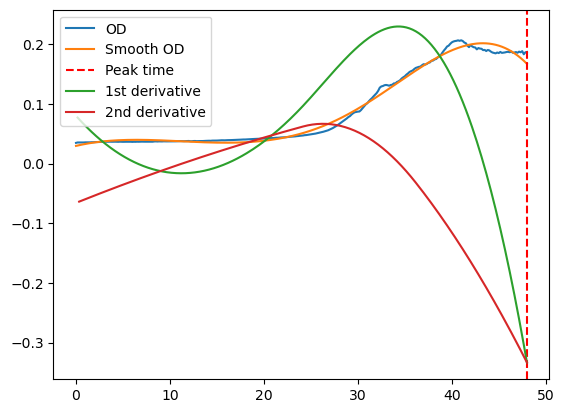

A04 38.66666667 0.99


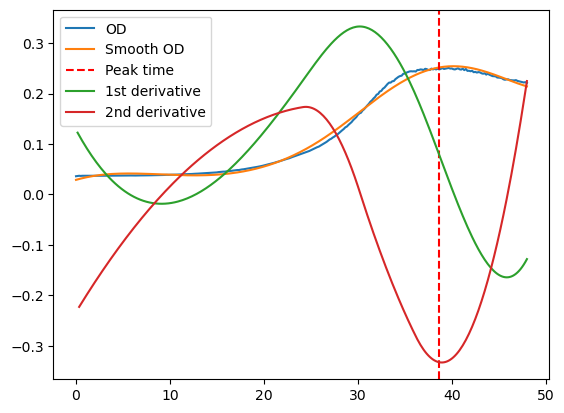

55 0.1
161 0.57
B04 37.5 0.81


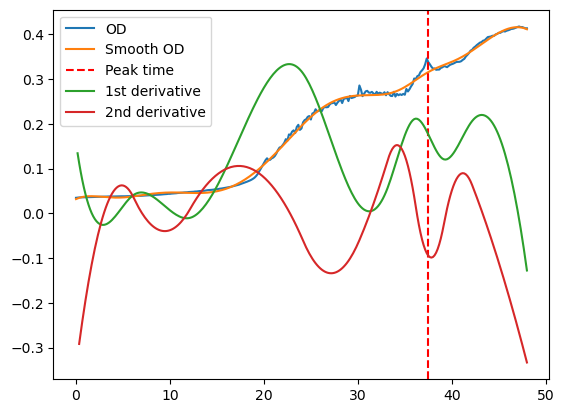

C04 48.0 1.0


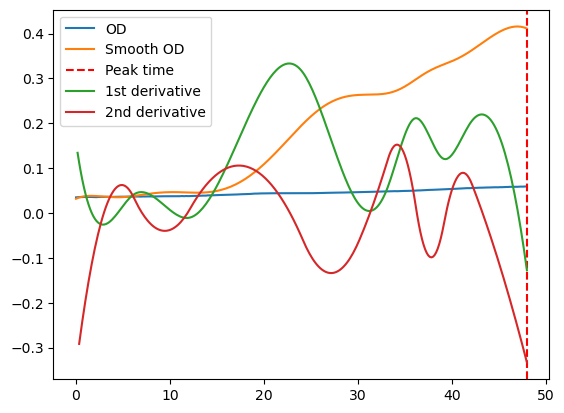

D04 48.0 1.0


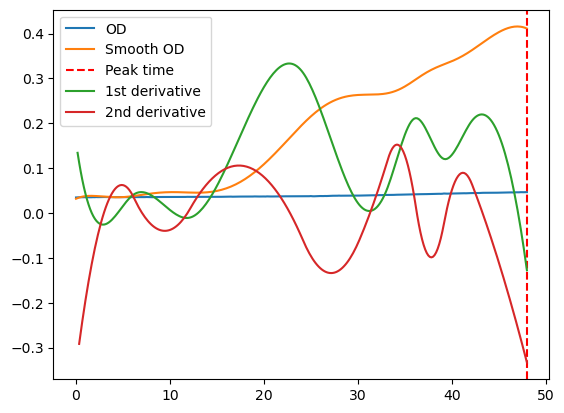

90 0.1
A05 48.0 1.0


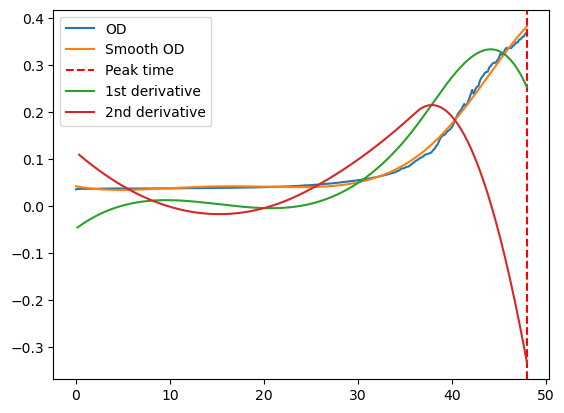

35 0.09
B05 15.5 0.74


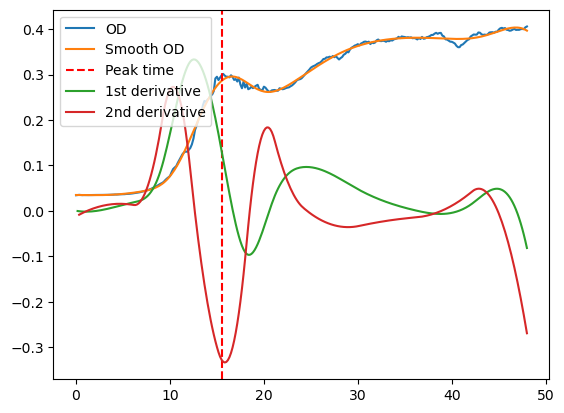

C05 48.0 1.0


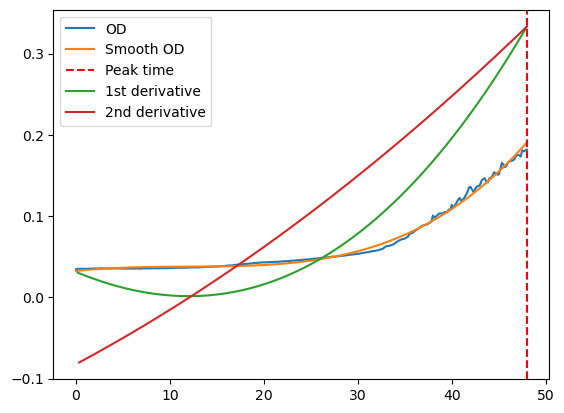

D05 48.0 1.0


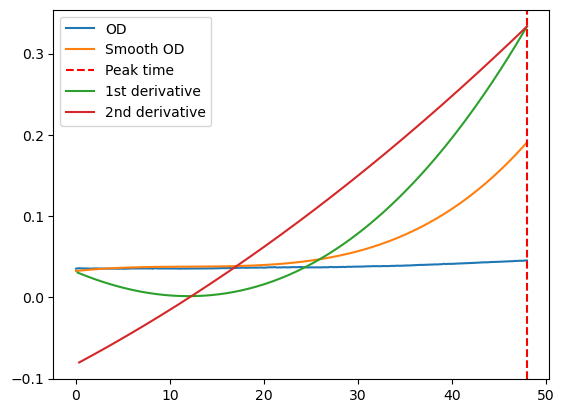

A06 34.66666667 0.99


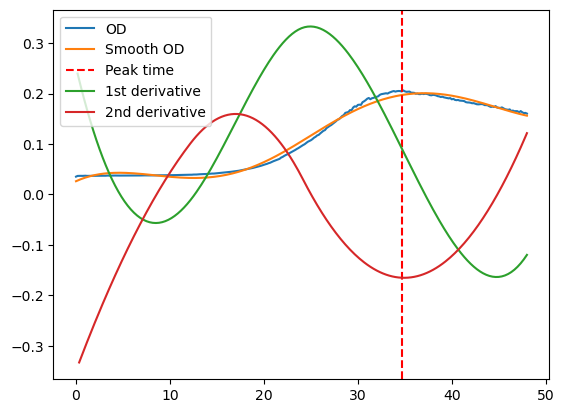

B06 20.5 0.63


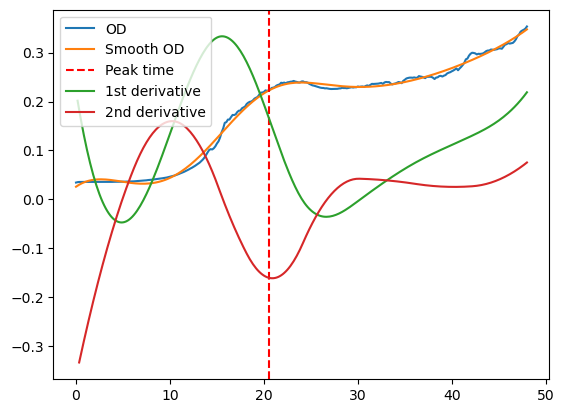

C06 48.0 0.99


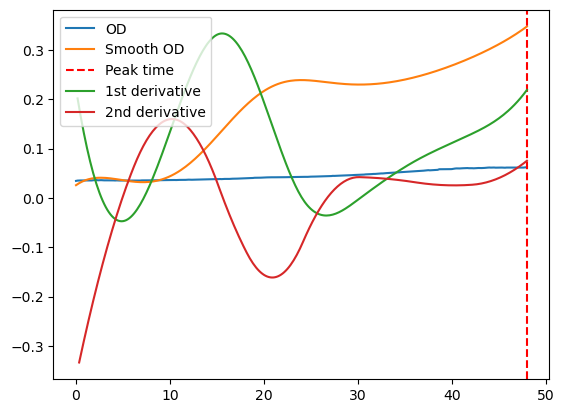

D06 48.0 1.0


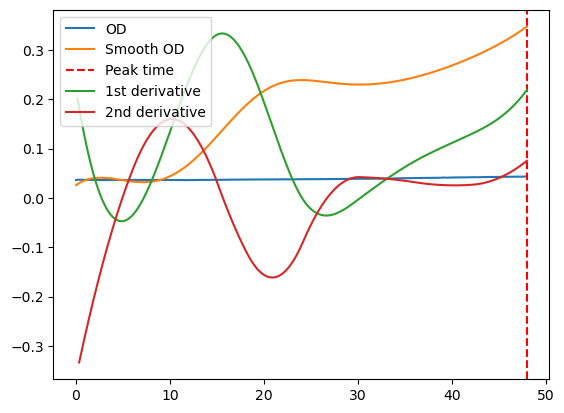

A07 48.0 1.0


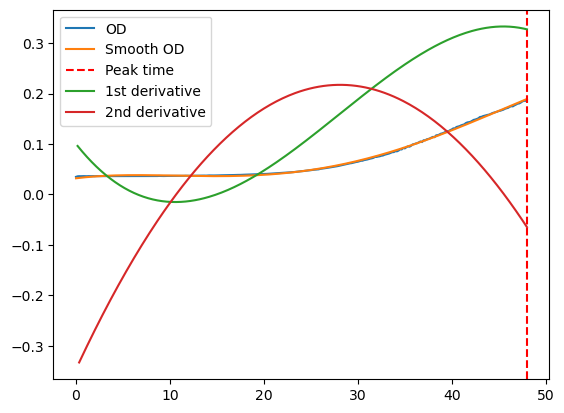

B07 21.33333333 0.71


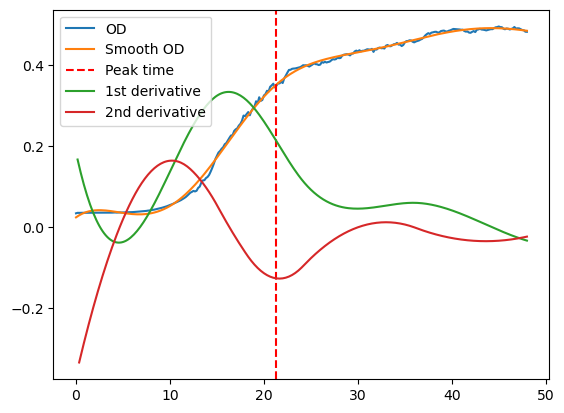

69 0.12
C07 34.33333333 0.95


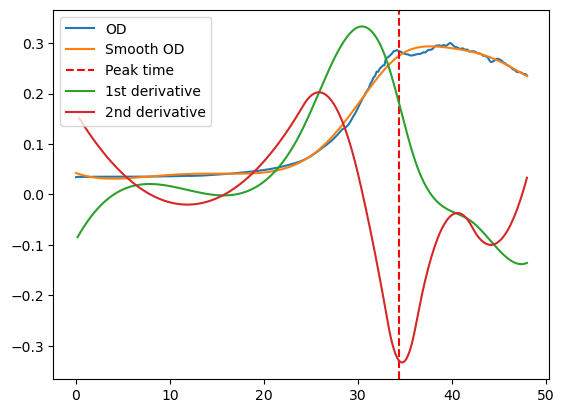

D07 48.0 1.0


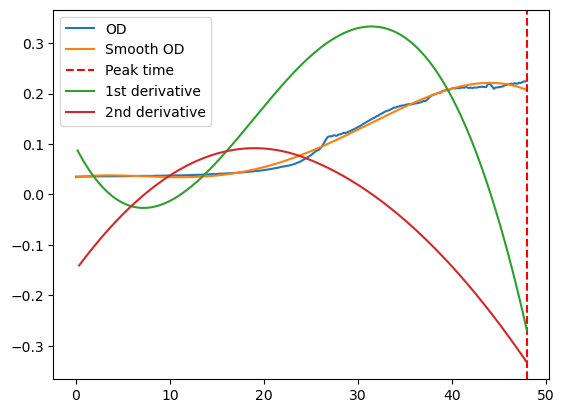

101 0.35
A08 48.0 1.0


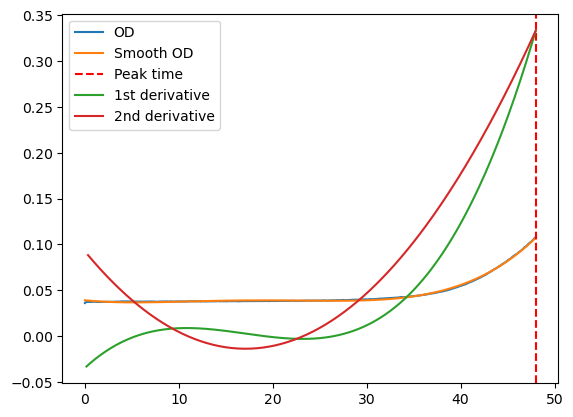

52 0.12
194 0.49
B08 48.0 1.0


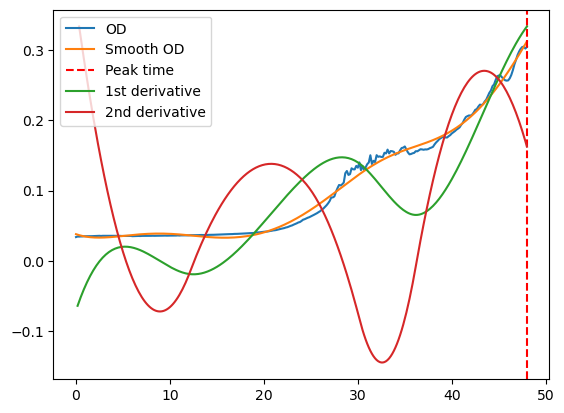

C08 31.0 0.82


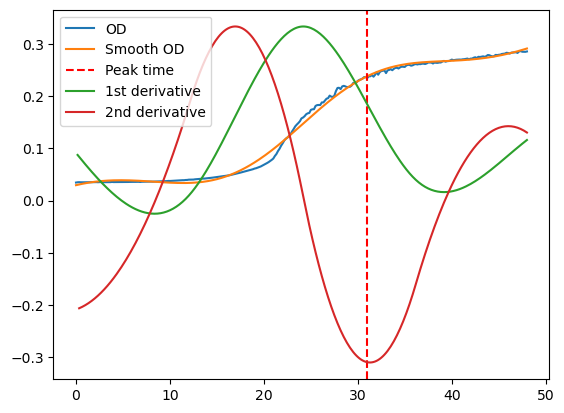

D08 21.5 0.72


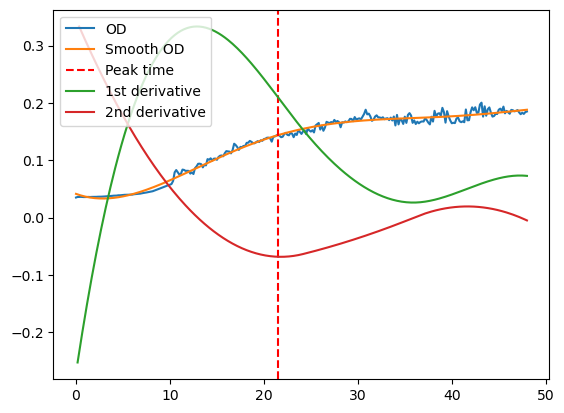

A09 48.0 1.0


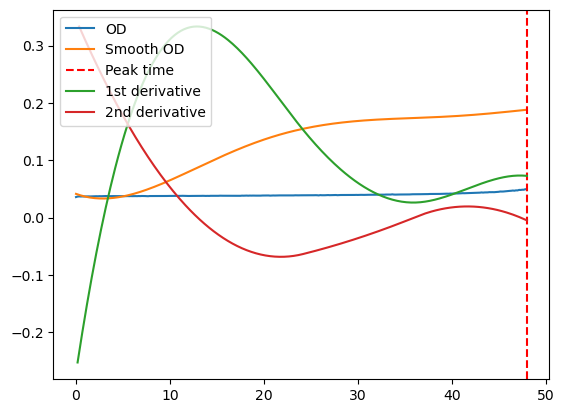

B09 48.0 1.0


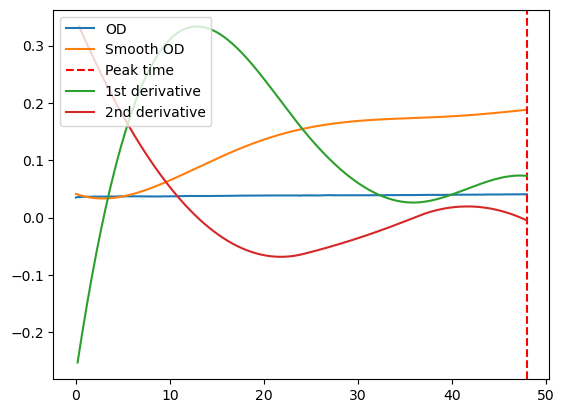

71 0.09
109 0.3
C09 21.83333333 0.73


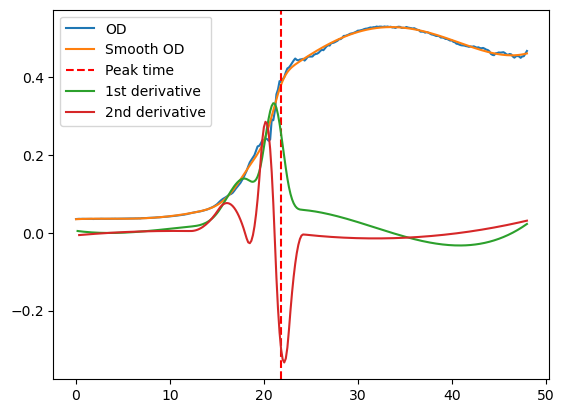

D09 18.83333333 0.84


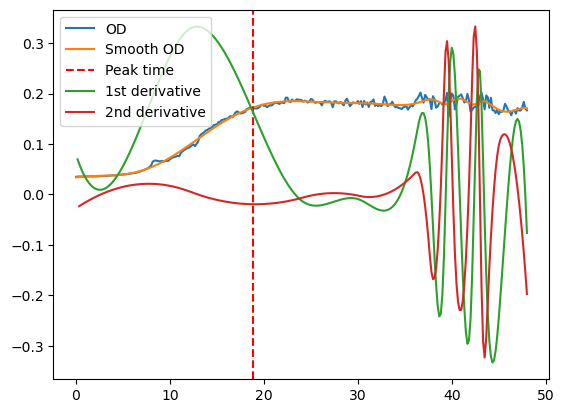

A10 48.0 1.0


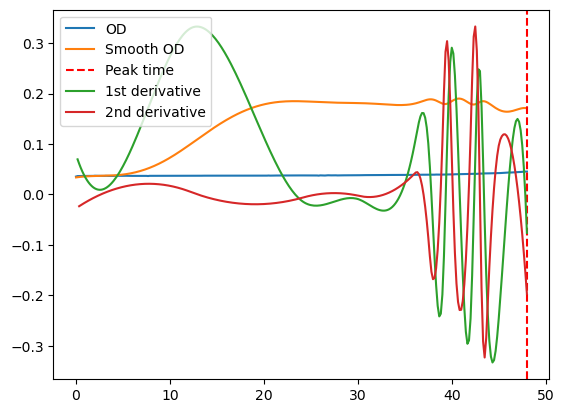

B10 48.0 1.0


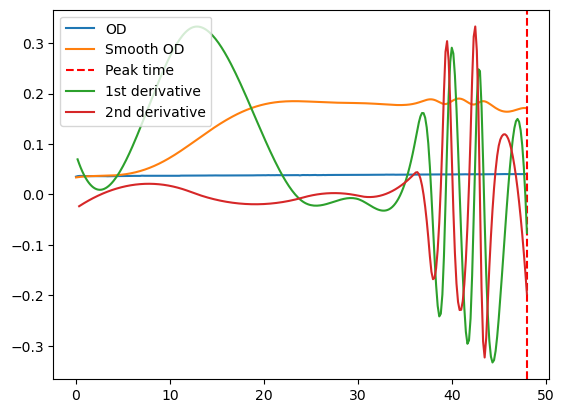

35 0.07
C10 18.33333333 0.62


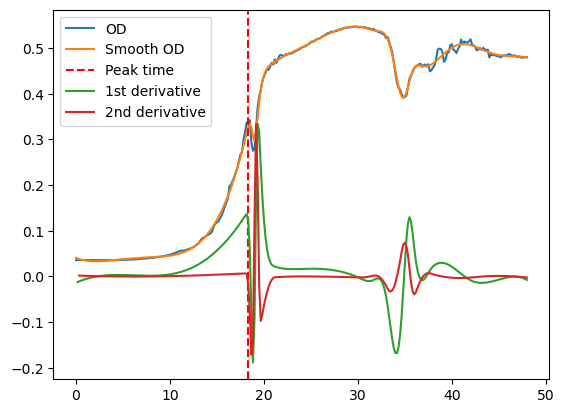

D10 15.5 0.81


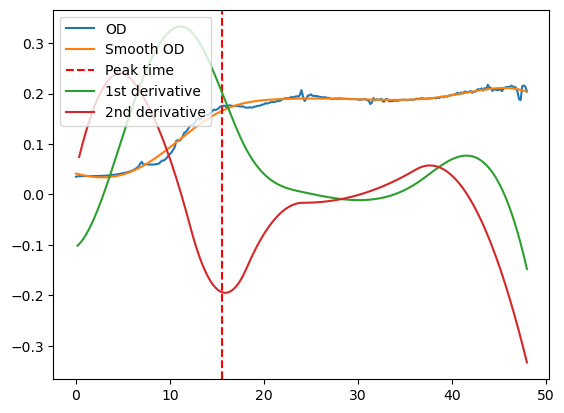

108 0.42
A11 48.0 1.0


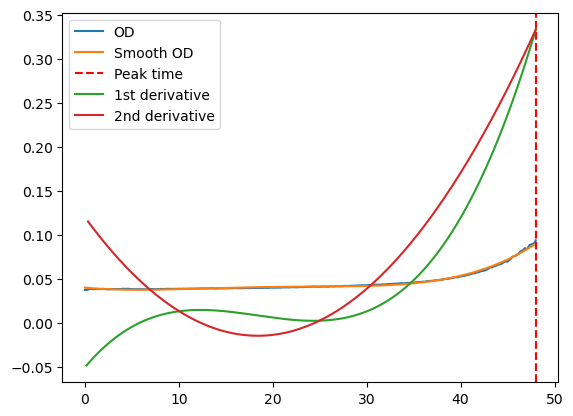

119 0.38
B11 35.33333333 0.78


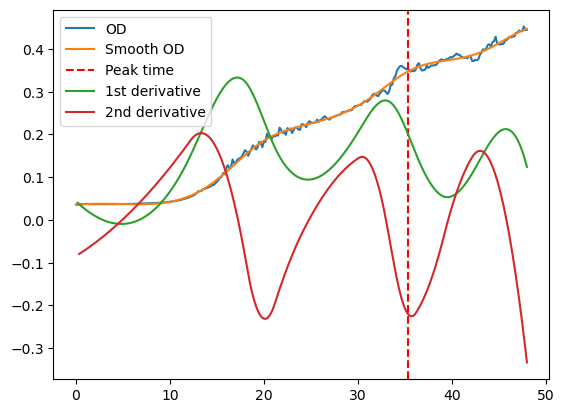

47 0.09
C11 19.66666667 0.73


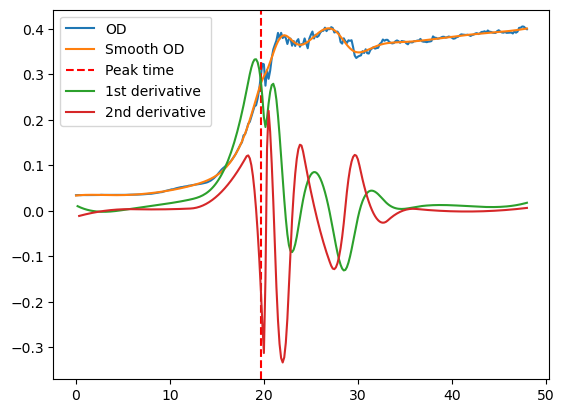

10 0.1
32 0.15
D11 15.16666667 0.65


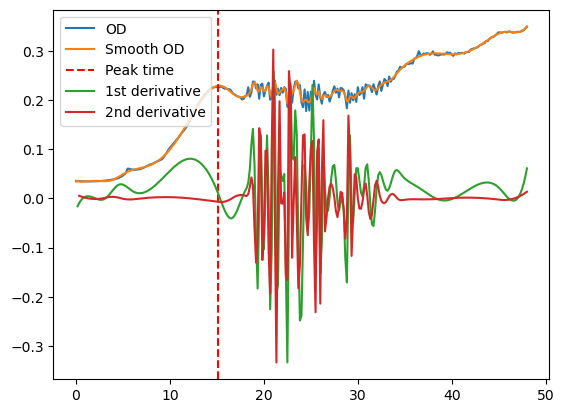

A12 48.0 0.99


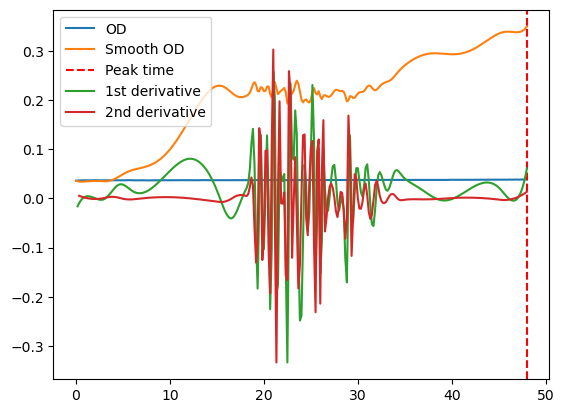

B12 48.0 0.99


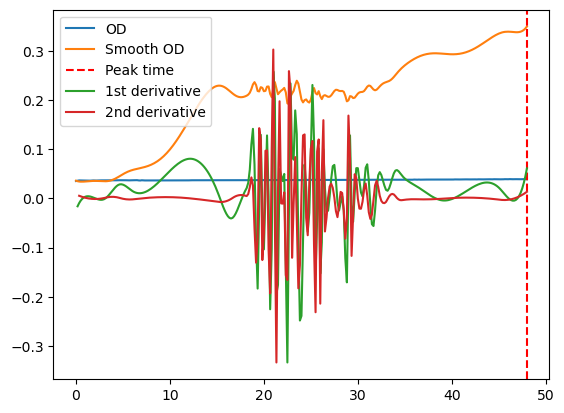

67 0.08
184 0.1
C12 46.0 0.96


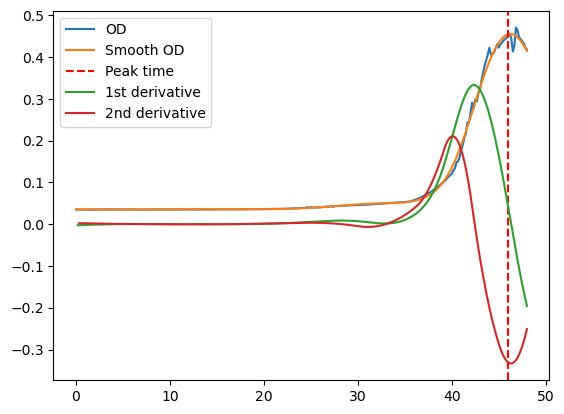

144 0.09
D12 42.5 0.7


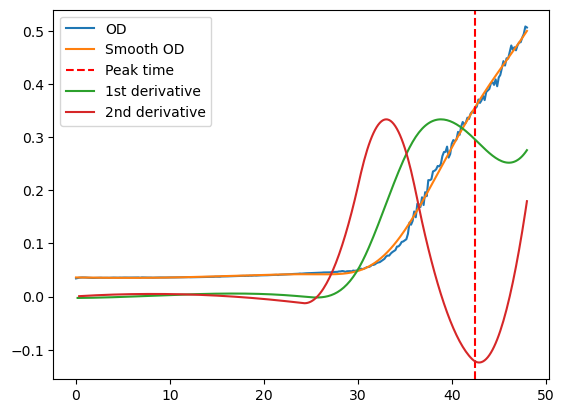

44 0.11
E02 28.66666667 0.92


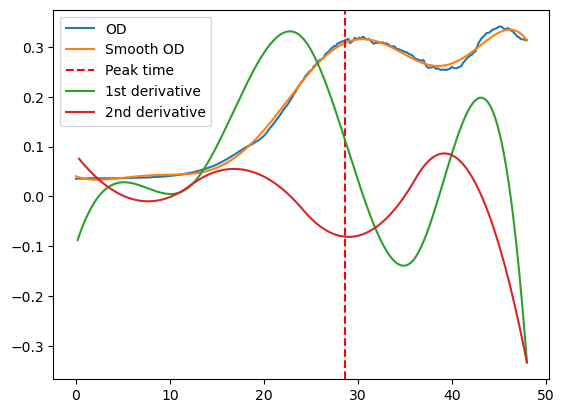

22 0.09
F02 13.16666667 0.86


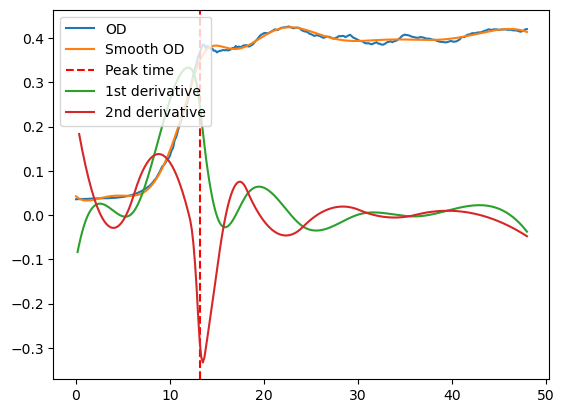

75 0.1
126 0.36
G02 23.5 0.83


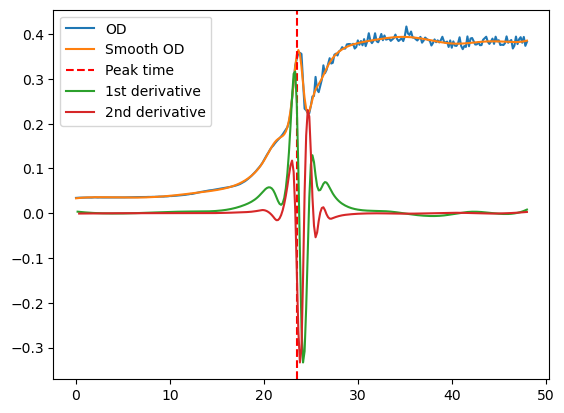

H02 35.83333333 0.92


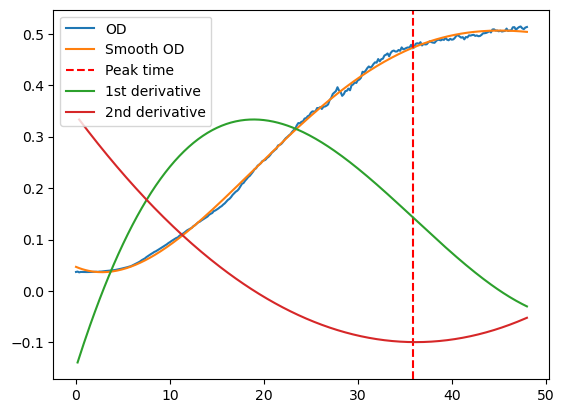

E03 34.16666667 0.99


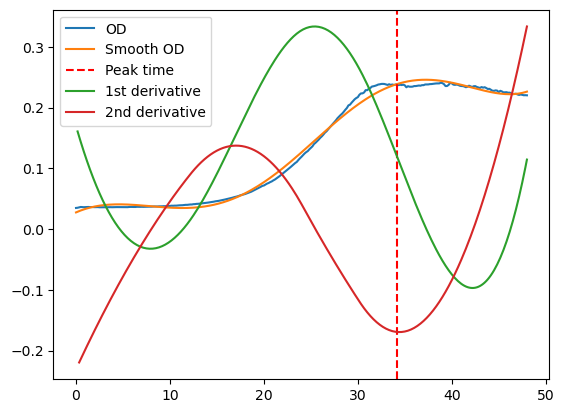

27 0.1
F03 15.33333333 0.91


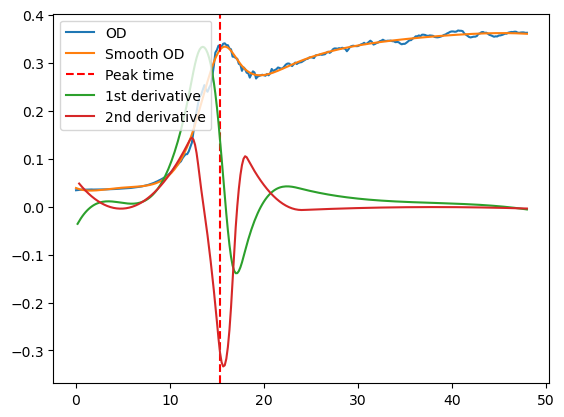

71 0.13
G03 35.5 0.9


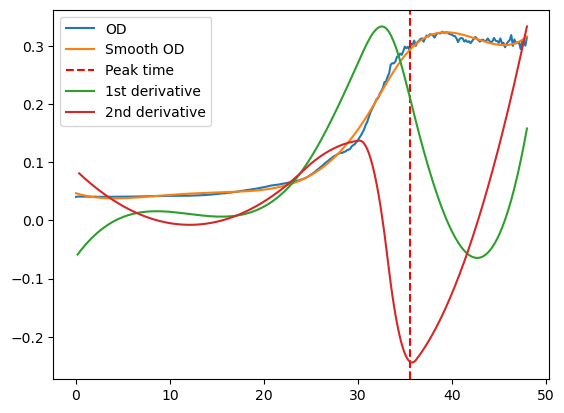

42 0.11
H03 48.0 1.0


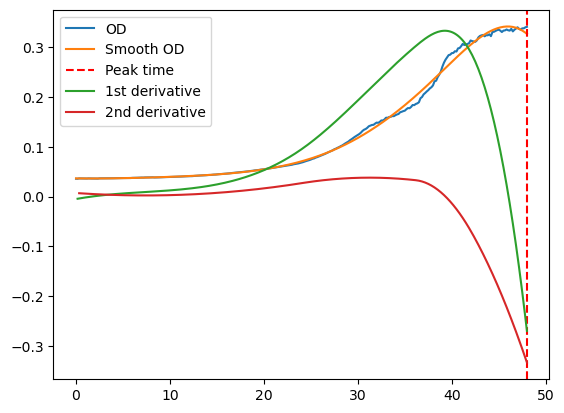

E04 48.0 0.99


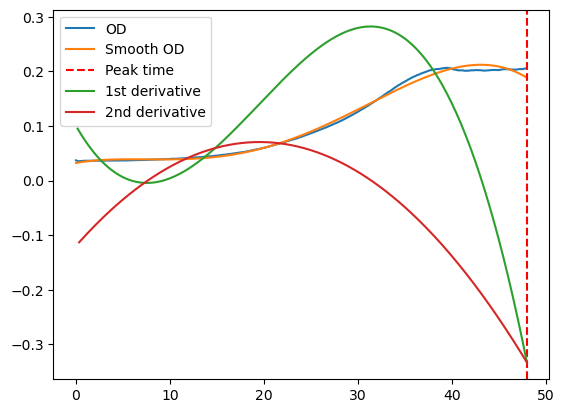

39 0.12
F04 27.16666667 0.77


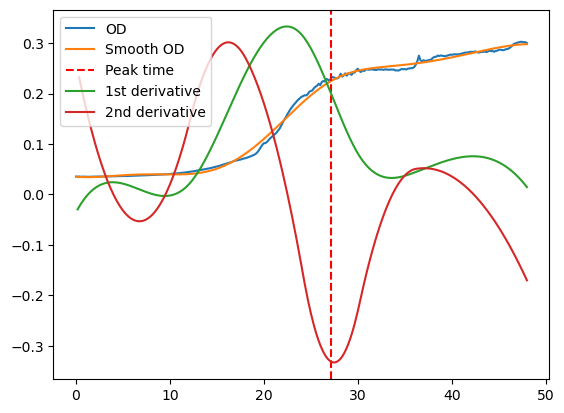

G04 48.0 1.0


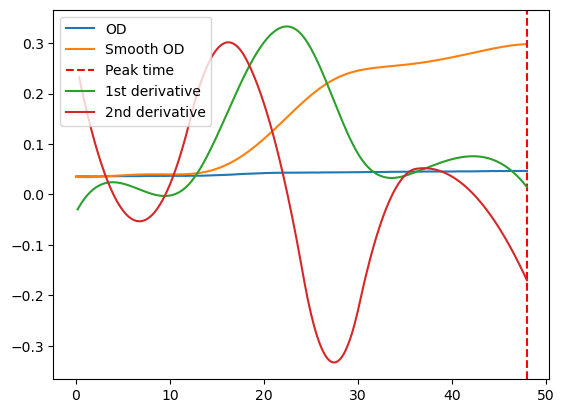

H04 48.0 1.0


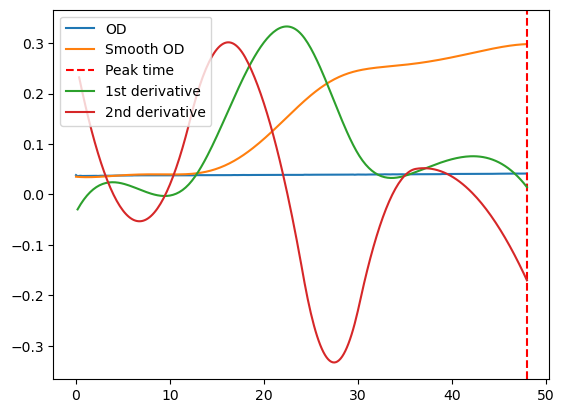

E05 48.0 0.99


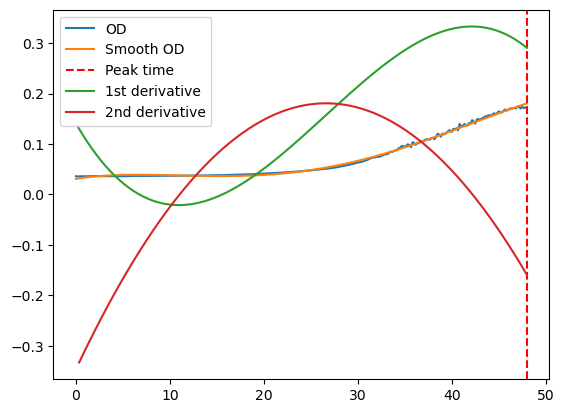

24 0.1
F05 14.33333333 0.74


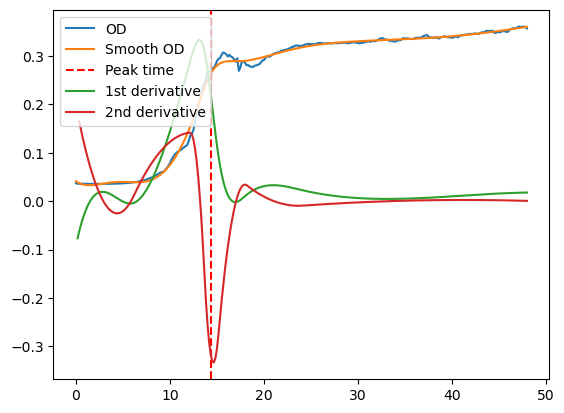

104 0.4
G05 48.0 1.0


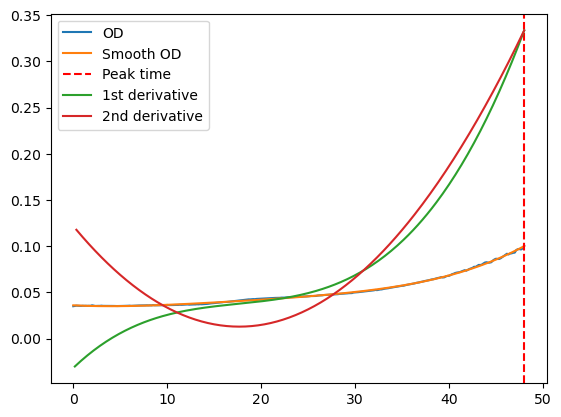

H05 48.0 1.0


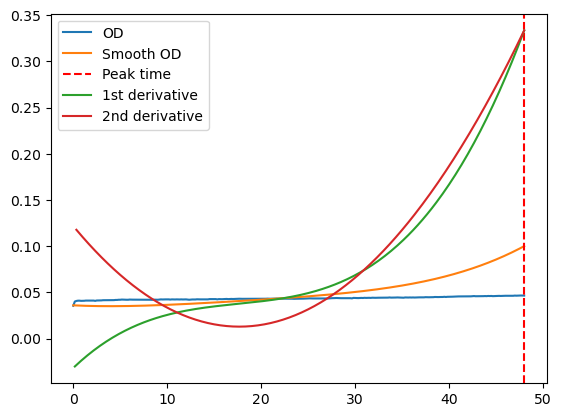

E06 37.16666667 0.97


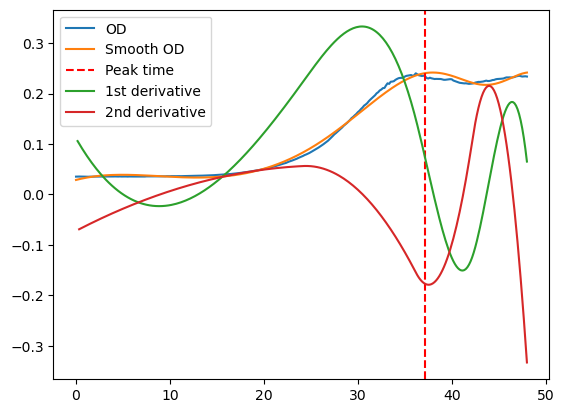

19 0.1
F06 20.0 0.65


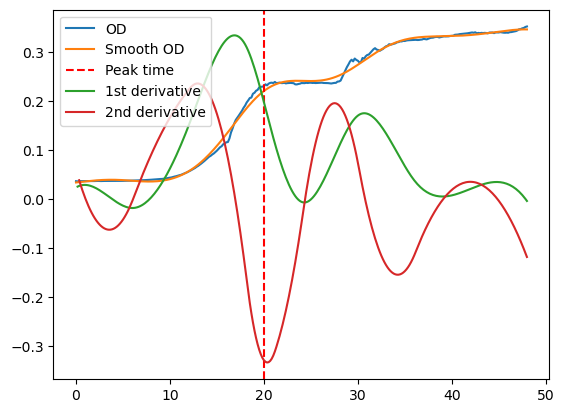

G06 48.0 1.0


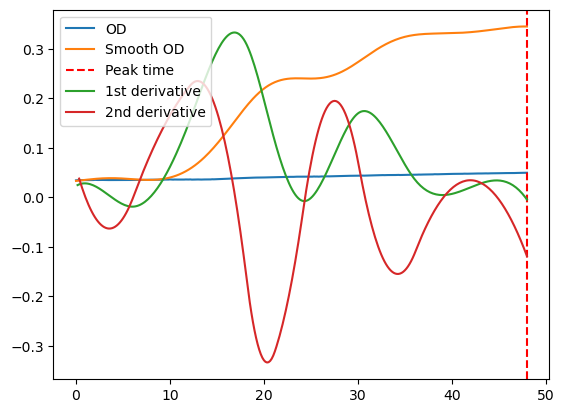

H06 48.0 1.0


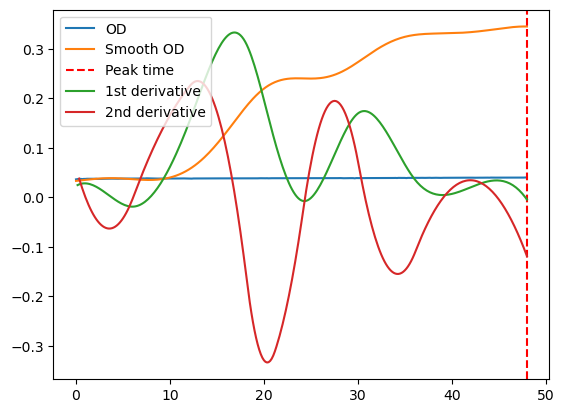

E07 48.0 1.0


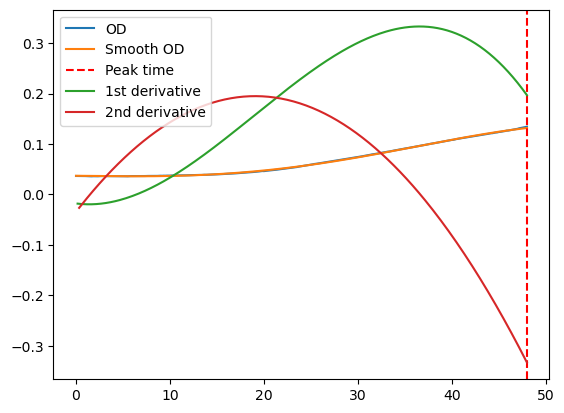

1 0.08
F07 20.66666667 0.66


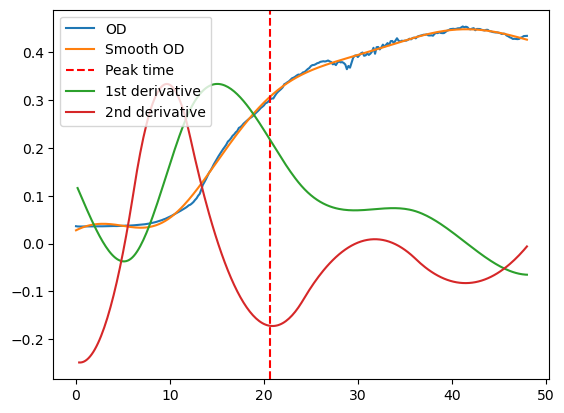

87 0.12
G07 33.16666667 0.85


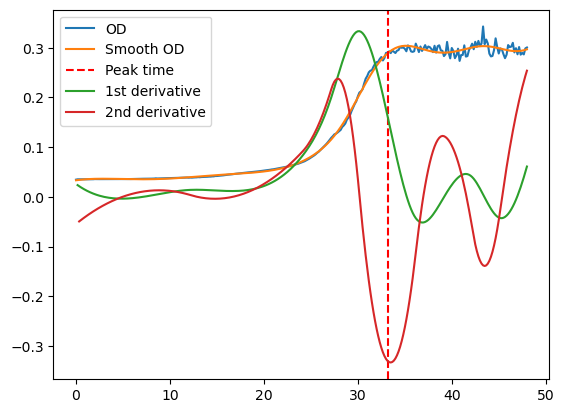

145 0.25
H07 48.0 1.0


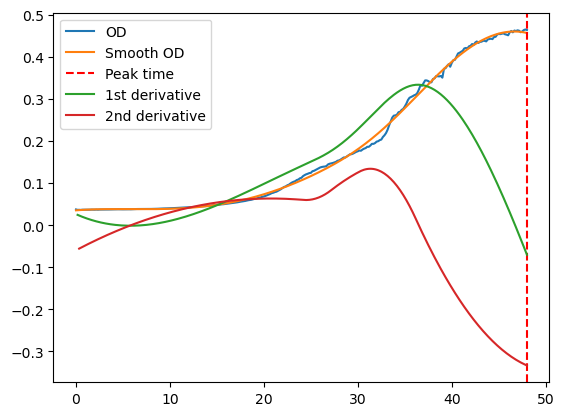

96 0.43
E08 48.0 1.0


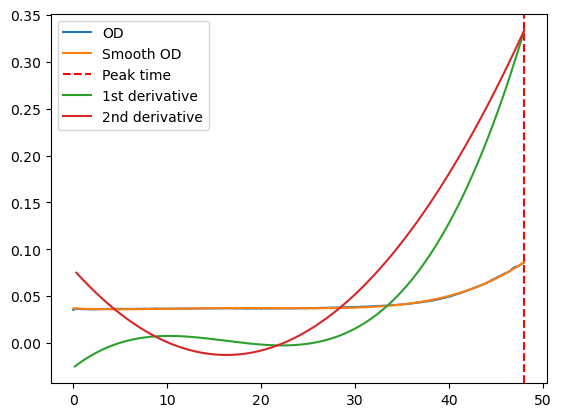

F08 37.5 0.8


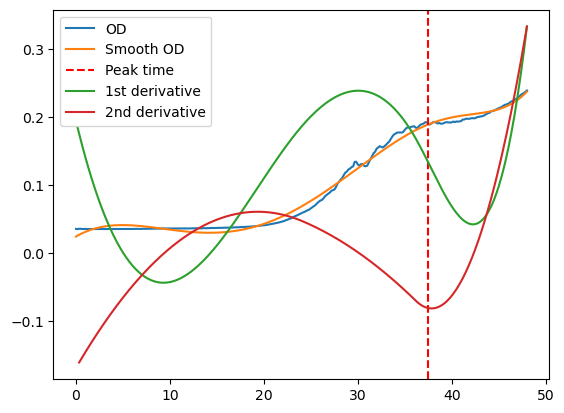

45 0.11
G08 29.66666667 0.8


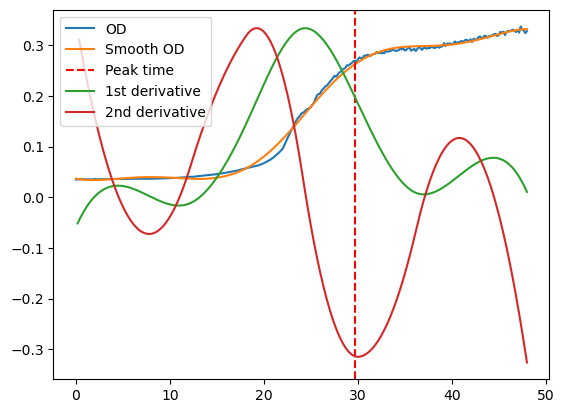

109 0.37
H08 32.5 0.81


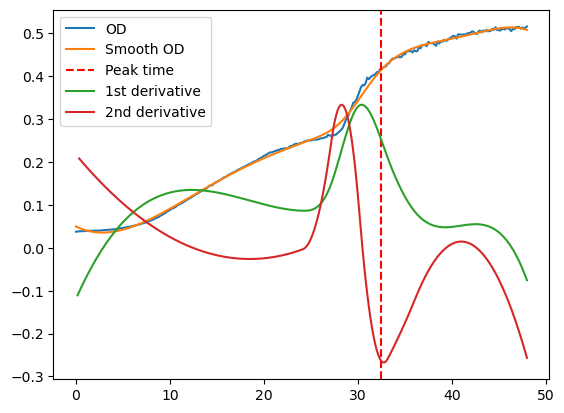

E09 48.0 1.0


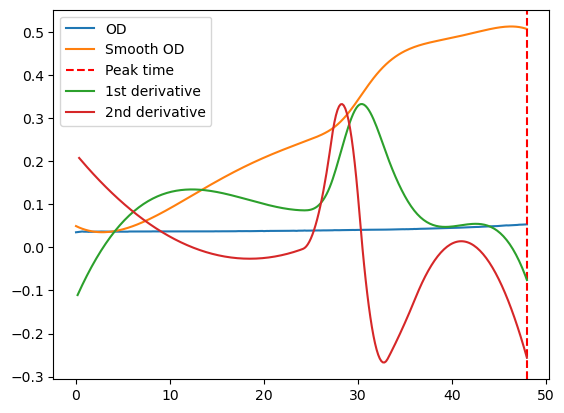

F09 48.0 1.0


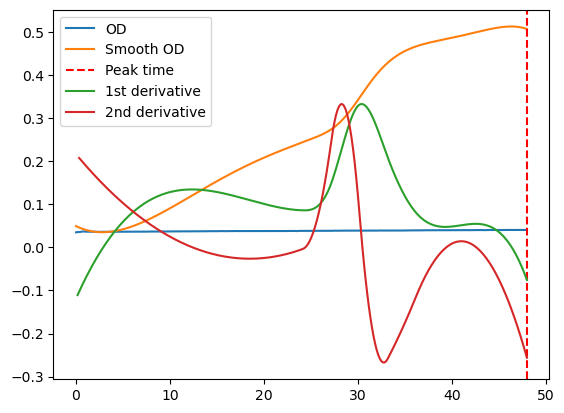

71 0.09
109 0.34
G09 21.83333333 0.76


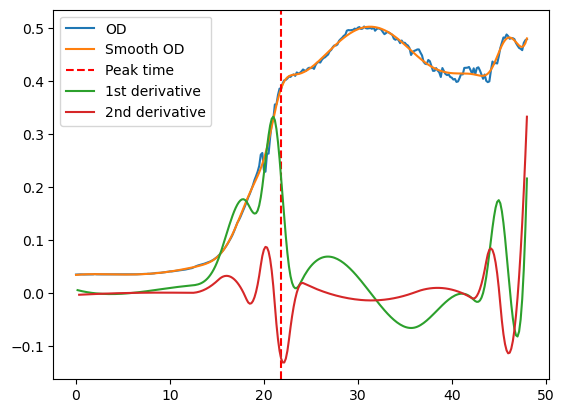

94 0.41
H09 38.66666667 0.91


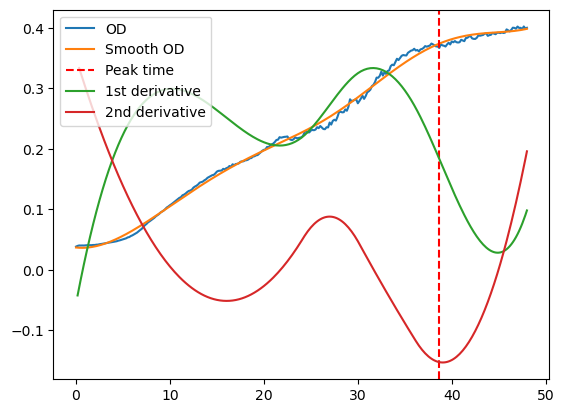

E10 48.0 1.0


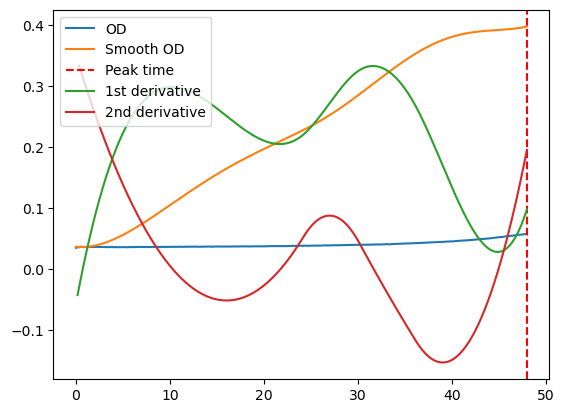

F10 48.0 1.0


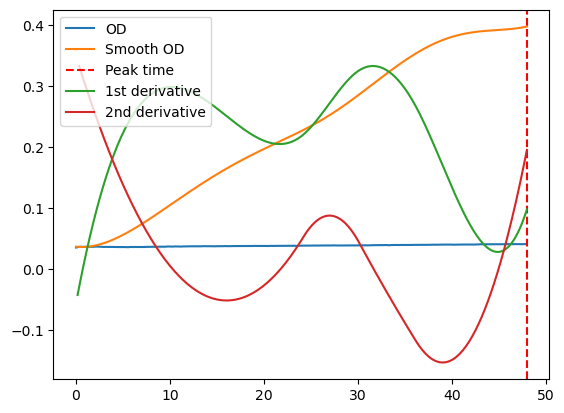

34 0.07
G10 18.16666667 0.67


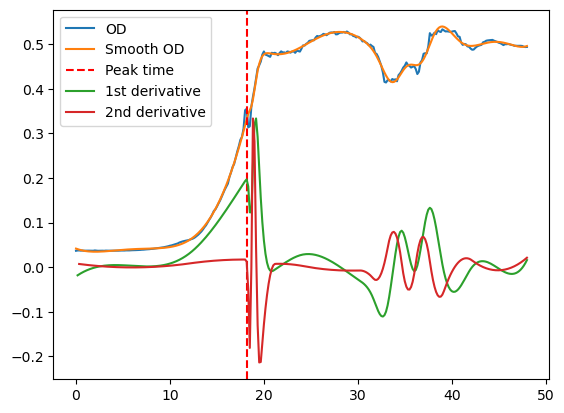

69 0.35
H10 34.0 0.93


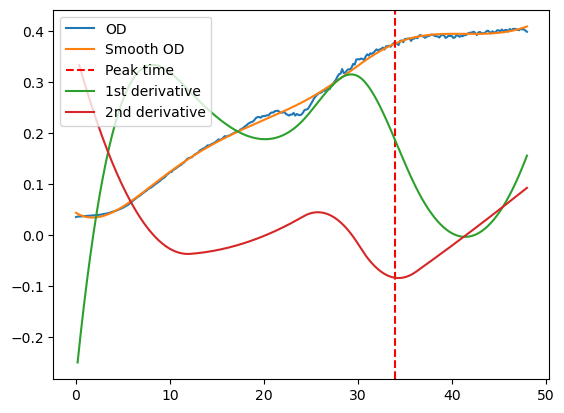

66 0.42
E11 48.0 1.0


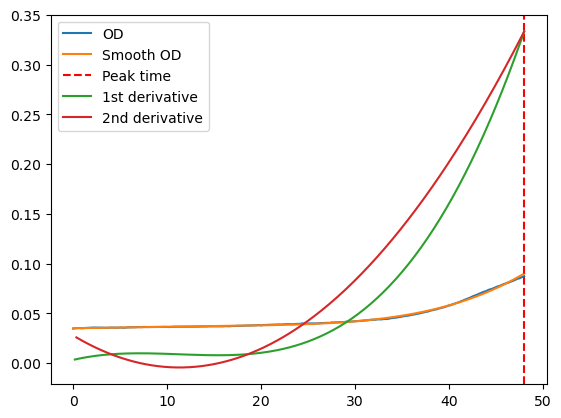

F11 29.33333333 0.69


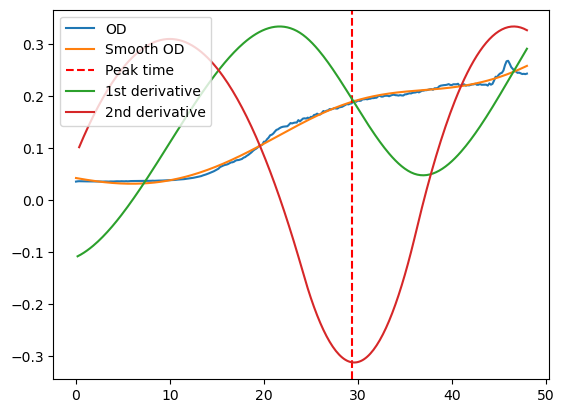

49 0.09
G11 20.16666667 0.84


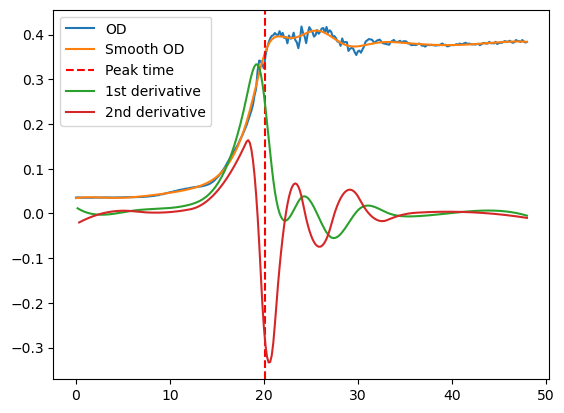

60 0.3
H11 30.0 0.95


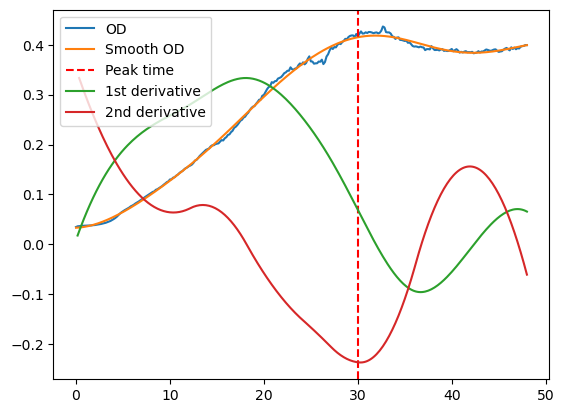

E12 48.0 1.0


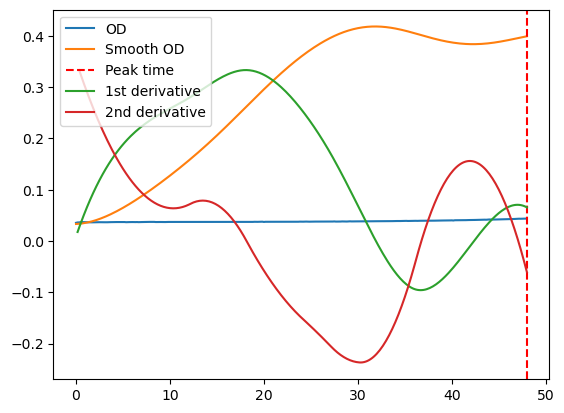

F12 48.0 1.0


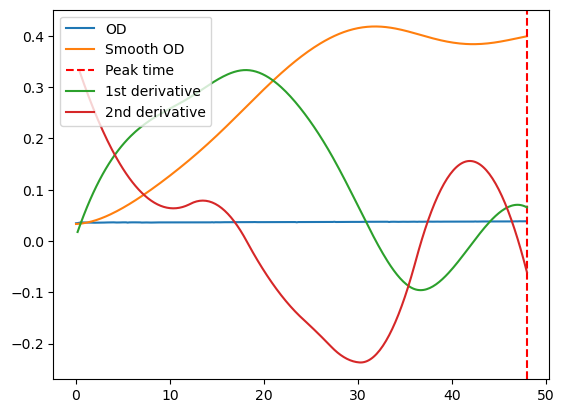

70 0.08
183 0.1
G12 42.83333333 0.86


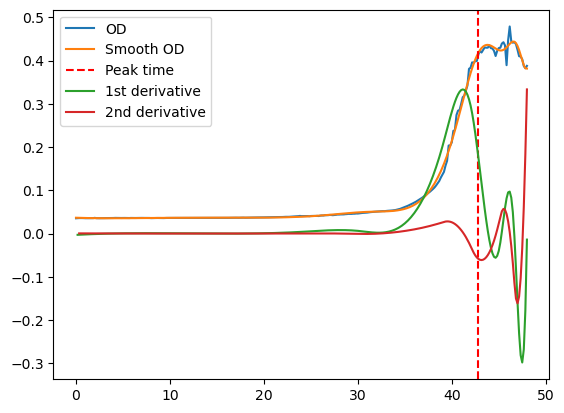

104 0.19
H12 48.0 1.0


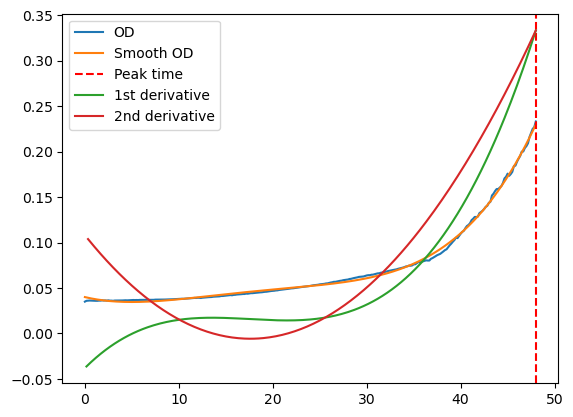

In [222]:
peak_times = []
od_threshold = 0.6
smoothing = 0.01
plot = True
skipped = 0

for w in growth_df.Well.unique():
    dfw = growth_df.loc[growth_df.Well==w].copy()
    dfw.sort_values(by='Time', inplace=True)

    s = dfw['Strain'].values[0]
    cs = dfw['Carbon_Source'].values[0]
    if cs == 'Ctrl':
        continue
    if (cs, s) in cs_to_drop:
        # skipped += 1
        peak_idx = -1
        # print(f'Skip {(w, cs, s)}')
    else:
        interp = scipy.interpolate.splrep(dfw.Time, dfw.OD, s=smoothing, k = 4)

        smooth2 = scipy.interpolate.splev(dfw.Time, interp)
        
        # # Apply a moving average to the OD column
        # window_size = 20  # Adjust the window size as needed
        # dfw['OD_smooth'] = dfw['OD'].rolling(window=window_size, center=True).mean()

        # # Replace `smooth2` with the smoothed OD values
        # smooth2 = dfw['OD_smooth'].fillna(method='bfill').fillna(method='ffill').values
        diff = np.diff(smooth2)
        diff2 = np.diff(diff)
        negative_peaks, peak_params = find_peaks(-diff2)#, height=0.2*np.max(-diff2))
        j = 0
        if len(negative_peaks):
            peak_idx = negative_peaks[j]
            while dfw.OD.iloc[peak_idx] < od_threshold*dfw.OD.max():
                print(peak_idx, np.round(dfw.OD.iloc[peak_idx]/dfw.OD.max(), 2))
                if j < len(negative_peaks)-1:
                    j += 1
                    peak_idx = negative_peaks[j]
                else:
                    peak_idx = -1
                    break
        else:
            peak_idx = -1
    
    peak_time = dfw.Time.iloc[peak_idx]
    peak_times.append([w,s,cs,peak_time])
    # print(len(diff), len(dfw.iloc[1:]))
    print(w, peak_time, np.round(dfw.OD.iloc[peak_idx]/dfw.OD.max(), 2))

    # dfw.sort_values(by='Time', inplace=True)
    # diff = np.diff(dfw.OD)
    if plot:
        plt.plot(dfw.Time, dfw.OD, label='OD')
        plt.plot(dfw.Time, smooth2, label = 'Smooth OD')
        plt.axvline(peak_time, color='red', linestyle='--', label = 'Peak time')
        plt.plot(dfw.Time.iloc[1:], diff/np.max(np.abs(diff))/3, label = '1st derivative')
        plt.plot(dfw.Time.iloc[2:], diff2/np.max(np.abs(diff2))/3, label = '2nd derivative')
        plt.legend(loc='upper left')
        plt.show()

# print(skipped)



In [223]:
peak_df = pd.DataFrame(peak_times, columns=['Well', 'Strain', 'Carbon source', 'Peak time'])
peak_df.to_csv(folder / 'growth_curves_peaktimes.csv')

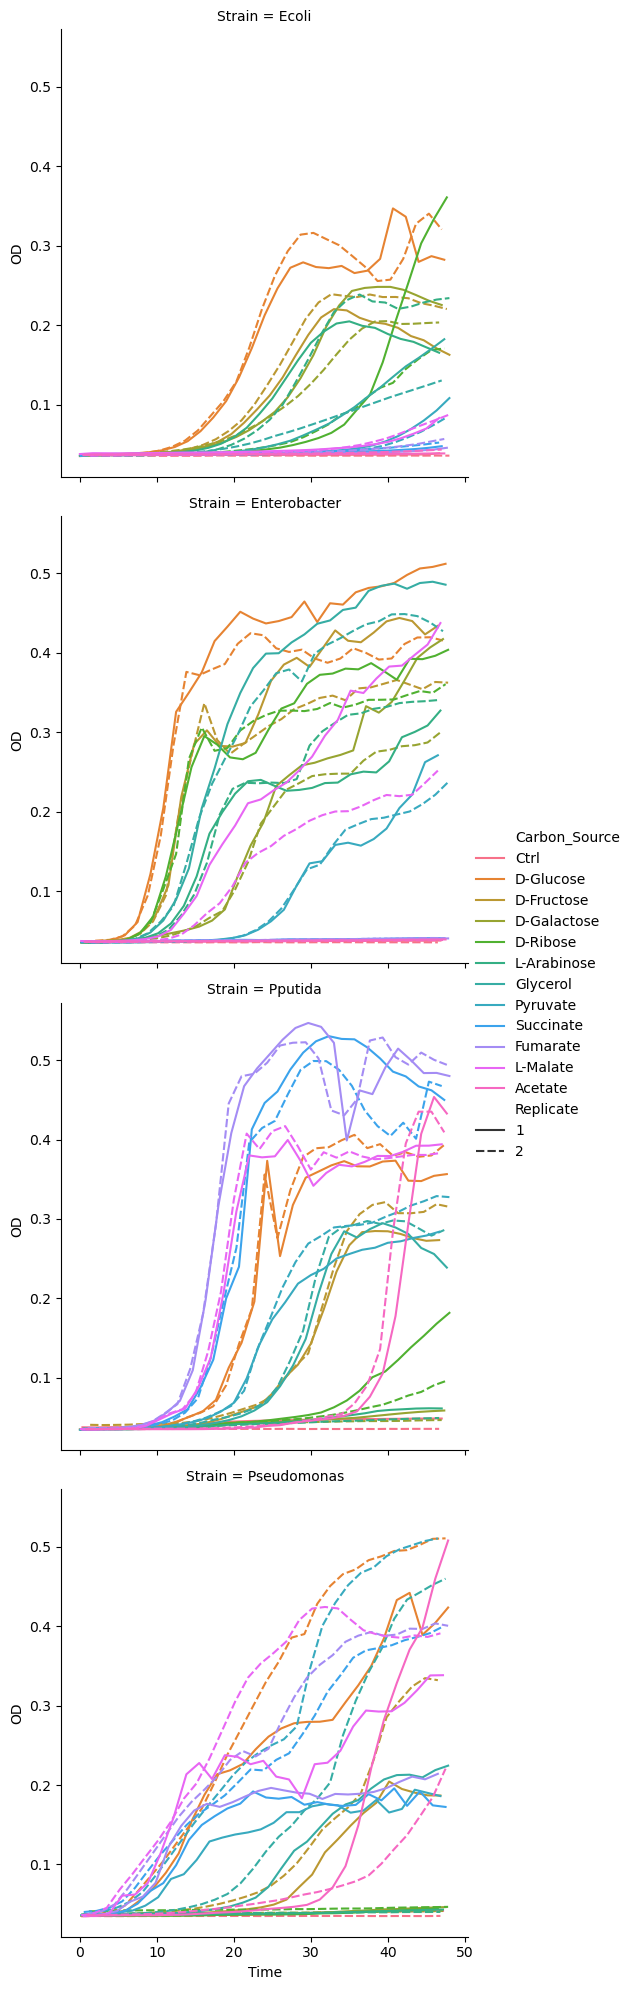

In [224]:
sns.relplot(data=growth_df.iloc[::10], x='Time', y='OD', hue='Carbon_Source', 
            col = 'Strain', kind='line', style='Replicate', col_wrap=1)

In [225]:
auc_data = []
for w in growth_df.Well.unique():
    dfw = growth_df.loc[growth_df.Well==w]
    s = dfw['Strain'].values[0]
    cs = dfw['Carbon_Source'].values[0]
    r = dfw['Replicate'].values[0]
    if (cs, s) in cs_to_drop:
        print(f'Skip {(w, cs, s)}')
        continue
    auc0 = 0
    for h in [16, 28, 48]:
        dfwh = growth_df[(growth_df.Well == w) & (growth_df.Time<= h)]
        delta_od = dfwh.OD.max() - dfwh.OD.min()
        auc_wh = auc(dfwh.Time, dfwh.OD)
        delta_auc = auc_wh-auc0
        auc0 = auc_wh
        auc_data.append([w,h, r, auc_wh, delta_od, dfwh.OD.max(), delta_auc])
auc_df = pd.DataFrame(auc_data, columns=['Well', 'Hours', 'Replicate', 'AUC', 'Delta OD', 'Max OD', 'Delta AUC'])

Skip ('A01', 'Ctrl', 'Ecoli')
Skip ('B01', 'Ctrl', 'Enterobacter')
Skip ('C01', 'Ctrl', 'Pputida')
Skip ('D01', 'Ctrl', 'Pseudomonas')
Skip ('C04', 'D-Galactose', 'Pputida')
Skip ('D04', 'D-Galactose', 'Pseudomonas')
Skip ('D05', 'D-Ribose', 'Pseudomonas')
Skip ('C06', 'L-Arabinose', 'Pputida')
Skip ('D06', 'L-Arabinose', 'Pseudomonas')
Skip ('A09', 'Succinate', 'Ecoli')
Skip ('B09', 'Succinate', 'Enterobacter')
Skip ('A10', 'Fumarate', 'Ecoli')
Skip ('B10', 'Fumarate', 'Enterobacter')
Skip ('A12', 'Acetate', 'Ecoli')
Skip ('B12', 'Acetate', 'Enterobacter')
Skip ('E01', 'Ctrl', 'Ecoli')
Skip ('F01', 'Ctrl', 'Enterobacter')
Skip ('G01', 'Ctrl', 'Pputida')
Skip ('H01', 'Ctrl', 'Pseudomonas')
Skip ('G04', 'D-Galactose', 'Pputida')
Skip ('H04', 'D-Galactose', 'Pseudomonas')
Skip ('H05', 'D-Ribose', 'Pseudomonas')
Skip ('G06', 'L-Arabinose', 'Pputida')
Skip ('H06', 'L-Arabinose', 'Pseudomonas')
Skip ('E09', 'Succinate', 'Ecoli')
Skip ('F09', 'Succinate', 'Enterobacter')
Skip ('E10', 'Fumara

In [226]:
well_to_cs = growth_df.groupby('Well').agg({'Carbon_Source':'first'}).to_dict()['Carbon_Source']
well_to_strain = growth_df.groupby('Well').agg({'Strain':'first'}).to_dict()['Strain']

In [227]:
auc_df['Carbon source'] = auc_df.Well.map(well_to_cs)
auc_df['Strain'] = auc_df.Well.map(well_to_strain)

In [228]:
# Mean of the 3 measured values and literature values (https://bmcbiophys.biomedcentral.com/articles/10.1186/2046-1682-6-4/tables/1)
    # https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=2&id=109837
ecoli_mean_gdw_to_od = np.mean([0.346, 0.279, 0.296, 0.36, 0.396, 0.515])
gDW_per_OD = {
    'Ecoli': ecoli_mean_gdw_to_od,
    'Enterobacter': ecoli_mean_gdw_to_od,
    'Pputida':np.mean([0.448, 0.505]),
    'Pseudomonas': np.mean([0.448, 0.505]) #pmc.ncbi.nlm.nih.gov/articles/PMC7809481/ https://pmc.ncbi.nlm.nih.gov/articles/PMC4656820
}

In [229]:
np.mean([0.448, 0.505])

np.float64(0.47650000000000003)

In [230]:
auc_df['gDW/OD'] = auc_df['Strain'].map(gDW_per_OD)
auc_df['AUC [gDW*h]'] = auc_df['AUC'] * auc_df['gDW/OD']

In [231]:
# auc_df.sort_values('Delta OD').loc[(auc_df['Max OD']<0.1)&(auc_df['Hours']>16)]
# auc_df.loc[auc_df.Hours==16, 'Delta AUC'] = auc_df.loc[auc_df.Hours==16, 'AUC']
# for i, row in auc_df.iterrows():
auc_df.head()

Well  Hours  Replicate       AUC  Delta OD  Max OD  Delta AUC Carbon source  \
0  A02     16          1  0.686658    0.0345  0.0697   0.686658     D-Glucose   
1  A02     28          1  2.718783    0.2418  0.2770   2.032125     D-Glucose   
2  A02     48          1  8.454217    0.3124  0.3476   5.735433     D-Glucose   
3  B02     16          1  2.381992    0.3473  0.3817   2.381992     D-Glucose   
4  B02     28          1  7.605992    0.4183  0.4527   5.224000     D-Glucose   

         Strain    gDW/OD  AUC [gDW*h]  
0         Ecoli  0.365333     0.250859  
1         Ecoli  0.365333     0.993262  
2         Ecoli  0.365333     3.088607  
3  Enterobacter  0.365333     0.870221  
4  Enterobacter  0.365333     2.778722

# Merge

In [232]:
growth_df

Well      OD       Time       Strain Carbon_Source  Replicate
0      A01  0.0350   0.000000        Ecoli          Ctrl          1
1      A01  0.0355   0.166667        Ecoli          Ctrl          1
2      A01  0.0357   0.333333        Ecoli          Ctrl          1
3      A01  0.0361   0.500000        Ecoli          Ctrl          1
4      A01  0.0360   0.666667        Ecoli          Ctrl          1
...    ...     ...        ...          ...           ...        ...
27739  H12  0.2162  47.333333  Pseudomonas       Acetate          2
27740  H12  0.2206  47.500000  Pseudomonas       Acetate          2
27741  H12  0.2251  47.666667  Pseudomonas       Acetate          2
27742  H12  0.2269  47.833333  Pseudomonas       Acetate          2
27743  H12  0.2332  48.000000  Pseudomonas       Acetate          2

[27744 rows x 6 columns]

In [233]:
df_exo = pd.merge(left = dft, right=auc_df, left_on=('Carbon source', 'Strain', 'Timepoint', 'Replicate'), right_on=('Carbon source', 'Strain', 'Hours', 'Replicate'), how = 'left')

In [234]:
# Remove metabolites data measured in the same cs environments
print(df_exo.Metabolite.unique())
print(df_exo['Carbon source'].unique())
cs_to_met = {
    'D-Glucose': 'D-glucose',
    'L-Malate': 'L-Malate',
    'Acetate': 'Acetic acid',
    'D-Fructose': 'D-Fructose',
    'D-Galactose': 'D-Galactose',
    'D-Ribose': 'D-Ribose',
    'L-Arabinose': 'L-Arabinose',
    'Glycerol': 'Glycerol',
    'Pyruvate': 'Pyruvic acid',
    'Succinate': 'Succinic acid',
    'Fumarate': 'Fumaric acid',
}
df_exo['cs_translated'] = df_exo['Carbon source'].map(cs_to_met)
df_exo = df_exo.loc[df_exo['cs_translated']!=df_exo['Metabolite']].copy()

['alpha-Ketoglutaric acid' 'Butyric acid' 'Valine' 'Pyruvic acid'
 'Propionic acid' 'Acetyl-ornithine' 'Alanine' 'Acetic acid' 'Asparagine'
 'beta-Hydroxybutyric acid' 'Serine' 'Glycine' 'Succinic acid'
 'Methionine' 'Fumaric acid' 'Valeric acid' 'Citric acid' 'Lactic acid'
 'Putrescine' 'Hippuric acid']
['D-Glucose' 'L-Malate' 'Acetate' 'D-Fructose' 'D-Galactose' 'D-Ribose'
 'L-Arabinose' 'Glycerol' 'Pyruvate' 'Succinate' 'Fumarate']


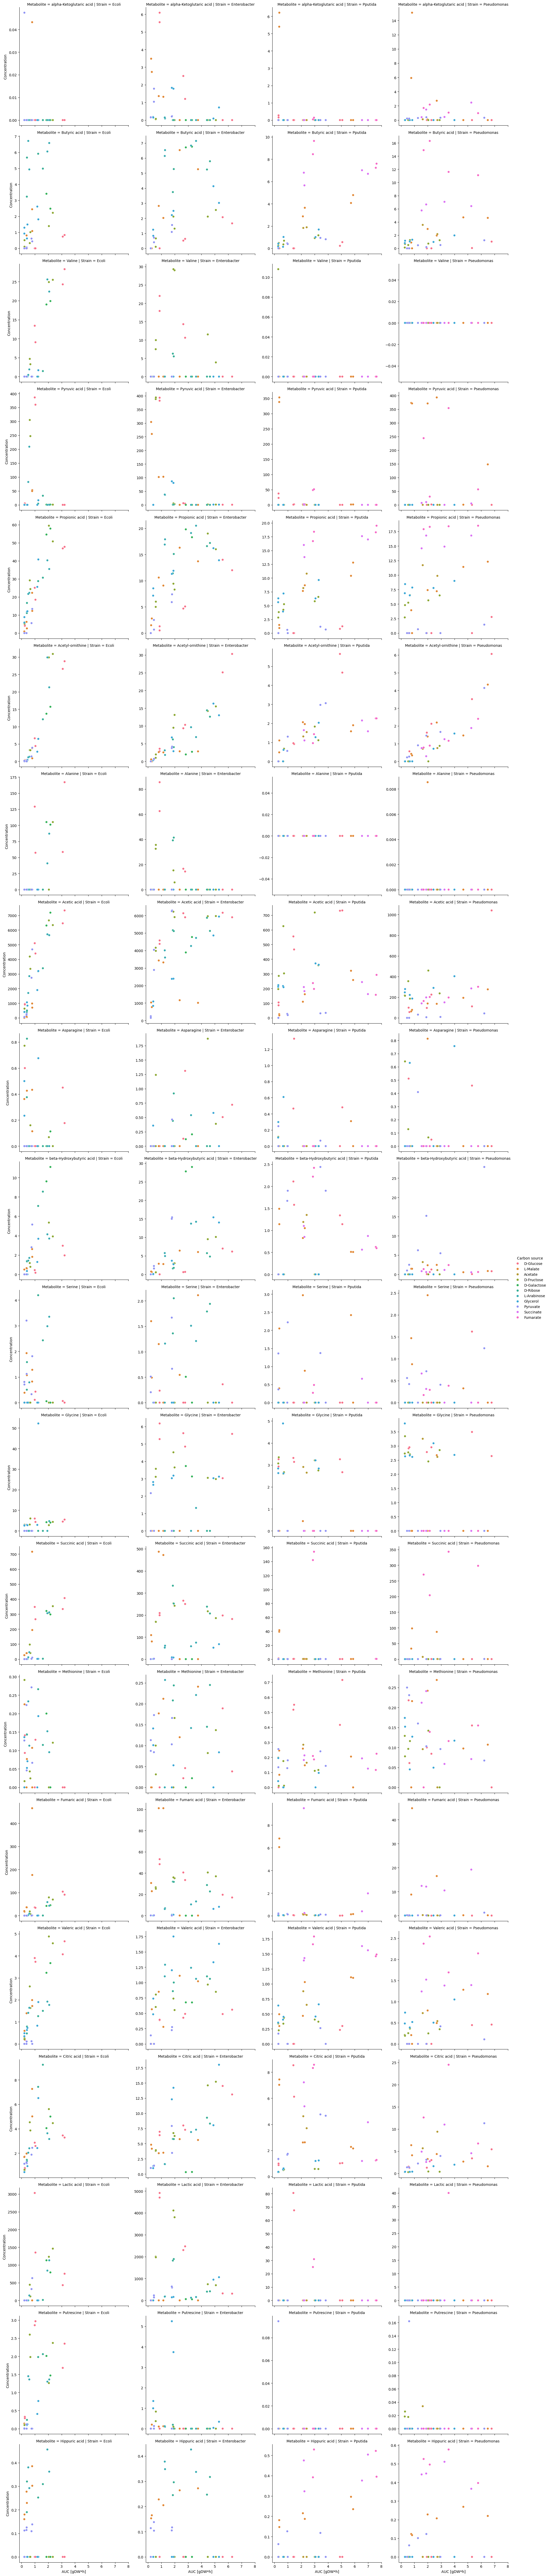

In [235]:
sns.relplot(df_exo, x = 'AUC [gDW*h]', y = 'Concentration', col = 'Strain', 
            row = 'Metabolite', facet_kws={'sharey':False}, hue = 'Carbon source')

# Estimate rates

In [236]:
strain_cs_to_PT = peak_df.groupby(['Strain', 'Carbon source']).agg({'Peak time':'max'}).to_dict()['Peak time']


In [237]:
time_buffer = 2
rate_data = []
plot = False
for s in df_exo.Strain.unique():
    for m in df_exo.Metabolite.unique():
        for cs in df_exo['Carbon source'].unique():
            dfcs = df_exo.loc[(df_exo.Strain==s)&(df_exo['Carbon source']==cs)&(df_exo.Metabolite==m)]
            if not len(dfcs):
                continue
            peak_time = max(16, strain_cs_to_PT[(s, cs)])
            fit_idx = dfcs.Hours <= (peak_time + time_buffer)
            if not len(dfcs.loc[fit_idx]):
                continue

            xvals = dfcs.loc[fit_idx, 'AUC [gDW*h]'].values
            yvals = dfcs.loc[fit_idx, 'Concentration'].values
            xvals = xvals[yvals>0]
            yvals = yvals[yvals>0]

            if len(yvals) < 2:
                continue
            n_replicates = dfcs.loc[fit_idx & (dfcs.Concentration >0), 'Replicate'].nunique()
            n_timepoints = dfcs.loc[fit_idx & (dfcs.Concentration >0), 'Hours'].nunique()
            if (n_timepoints > 1) & (len(yvals) > 2):
                # print(dfcs.loc[fit_idx & (dfcs.Concentration >0), 'Hours'].unique(), dfcs.loc[fit_idx & (dfcs.Concentration >0), 'Hours'].nunique())
                fit_result_no_0 = st.linregress(xvals, yvals)
            
            #     xvals = np.concatenate((np.zeros((len(yvals))), xvals))  # Prepend two zeros
            #     yvals = np.concatenate((np.zeros((len(yvals))), yvals))

            xvals = np.concatenate((np.zeros((n_replicates)), xvals))  # Prepend two zeros
            yvals = np.concatenate((np.zeros((n_replicates)), yvals))
            

            fit_result = st.linregress(xvals, yvals)
            
            if (n_timepoints > 1) & (len(yvals) > 2):
                if np.sign(fit_result.slope) != np.sign(fit_result_no_0.slope):
            #         print(dfcs.loc[fit_idx])
                    print('Not including 0', s, cs, m)
                    fit_result = fit_result_no_0

            xarr = np.linspace(0, xvals.max(), 100)
            yarr = fit_result.intercept + fit_result.slope * xarr
            rate_data.append([s, cs, m, fit_result.slope, fit_result.intercept, fit_result.rvalue**2, fit_result.stderr, peak_time])
            # plt.figure()
            # print(peak_time, s, cs, m, yvals)
            if plot:
                sns.scatterplot(dfcs, x = 'AUC [gDW*h]', y = 'Concentration', hue = 'Hours')
                plt.plot(xarr, yarr, 'r--')
                plt.title(f'{s} {m} {cs}')
                plt.show()
            # plt.xlabel('AUC')
            # plt.ylabel('Concentration')
            # plt.show()
            # break
            # break


Not including 0 Ecoli L-Malate Asparagine
Not including 0 Ecoli D-Fructose Asparagine
Not including 0 Ecoli L-Malate Methionine
Not including 0 Ecoli D-Fructose Methionine
Not including 0 Enterobacter L-Malate alpha-Ketoglutaric acid
Not including 0 Enterobacter L-Malate Pyruvic acid
Not including 0 Enterobacter Pyruvate Fumaric acid
Not including 0 Enterobacter L-Malate Valeric acid
Not including 0 Enterobacter L-Malate Citric acid
Not including 0 Enterobacter L-Malate Putrescine
Not including 0 Enterobacter Pyruvate Hippuric acid
Not including 0 Pputida Glycerol Propionic acid
Not including 0 Pputida Glycerol Acetic acid
Not including 0 Pputida D-Fructose Glycine
Not including 0 Pputida D-Fructose Methionine
Not including 0 Pputida Pyruvate Methionine
Not including 0 Pputida Pyruvate Fumaric acid
Not including 0 Pputida Glycerol Valeric acid
Not including 0 Pseudomonas Glycerol Asparagine
Not including 0 Pseudomonas D-Glucose Glycine
Not including 0 Pseudomonas D-Fructose Glycine
Not

In [238]:
df_rate = pd.DataFrame(rate_data, columns=['Strain', 'Carbon source', 'Metabolite', 'Slope', 'Intercept', 'R2', 'Std err', 'Peak time'])

# Convert from umol to mmol
df_rate['Rate [mmol/gDW/h]'] = df_rate['Slope']*1e-3
df_rate['Std. Err [mmol/gDW/h]'] = df_rate['Std err']*1e-3

# Estimate growth rates

# Read in estimated growth rates


In [239]:
growth_rates_fn = folder / 'growth_curves_fits.csv'
growth_rates_df = pd.read_csv(growth_rates_fn, index_col=0)

# Load metabolic models to estimate values

In [240]:
model_ez = reframed.load_cbmodel('../../../models/e_coli/momentiJO1366_modified.xml')
model_ez.solver = 'gurobi'
model_ez.reactions.R_EX_glc__D_e.lb = 0

In [241]:
model_pp_fn = '../../../models/p_putida/eciJN1463_uniprot_AutoPACMEN.xml'
# '../../../models/p_putida/iJN1463.xml'
model_pp = reframed.load_cbmodel(model_pp_fn)


model_pp.solver = 'gurobi'

model_pp.reactions.R_EX_glc__D_e.lb = 0

### Verify that models have all carbon source uptake blocked

In [242]:
reframed.FBA(model_ez, objective=model_ez.biomass_reaction)

Objective: None
Status: Infeasible or Unbounded

In [243]:
reframed.FBA(model_pp, objective=model_pp.biomass_reaction)

Objective: None
Status: Infeasible or Unbounded

In [244]:
strain_to_model = {
    'Enterobacter': model_ez,
    'Ecoli': model_ez,
    'Pseudomonas': model_pp,
    'Pputida': model_pp,
}

# Mapping of metabolite names to bigg ids


In [245]:
translate_dict = {'alpha-Ketoglutaric acid': 'akg',
'Butyric acid': 'but',
'Valine': 'val__L',
'Pyruvic acid': 'pyr',
'Propionic acid': 'ppa',
'Acetyl-ornithine': 'acorn',
'Alanine': 'ala__L',
'Acetic acid': 'ac',
'Asparagine': 'asn__L',
'beta-Hydroxybutyric acid': 'bhb',
'Serine': 'ser__L',
'Glycine': 'gly',
'Succinic acid': 'succ',
'Methionine': 'met__L',
'Fumaric acid': 'fum',
'Valeric acid': 'pta',
'Citric acid': 'cit',
'Lactic acid': 'lac__D',
'Putrescine':  'ptrc',
'Hippuric acid': 'bgly'}
translate_dict_r = {value:key for key, value in translate_dict.items()}

In [246]:
cs_to_exchange = {'D-Glucose': 'EX_glc__D_e',
                'D-Lactate': 'EX_lac__D_e',
                'Citrate': 'EX_cit_e',
                '2-Oxoglutarate': 'EX_akg_e',
                'Succinate': 'EX_succ_e',
                'Fumarate': 'EX_fum_e',
                'L-Malate': 'EX_mal__L_e',
                'L-Glutamine': 'EX_gln__L_e',
                'Acetate': 'EX_ac_e',
                'D-Galactose': 'EX_gal_e',
                'D-Ribose': 'EX_rib__D_e',
                'L-Arabinose': 'EX_arab__L_e',
                'Glycerol': 'EX_glyc_e',
                'D-Gluconate': 'EX_glcn_e',
                '2-Ketogluconate': 'EX_25dkglcn_e',
                'Pyruvate': 'EX_pyr_e',
                'D-Fructose': 'EX_fru_e'}


In [247]:
measured_mets_ez = []
measured_metnames_ez = []
for key, value in translate_dict.items():
    m_id = f'M_{value}_c'
    try:
        m = model_ez.metabolites[m_id]
    except KeyError:
        print(f'{key} not in model')
    else:
        measured_mets_ez.append(m_id)
        measured_metnames_ez.append(key)

beta-Hydroxybutyric acid not in model
Valeric acid not in model
Hippuric acid not in model


In [248]:
measured_mets_pp = []
measured_metnames_pp = []
for key, value in translate_dict.items():
    m_id = f'M_{value}_c'
    try:
        m = model_pp.metabolites[m_id]
    except KeyError:
        print(f'{key} not in model')
    else:
        measured_mets_pp.append(m_id)
        measured_metnames_pp.append(key)

Hippuric acid not in model


In [249]:
metnames_dict = {
    'Enterobacter': (measured_mets_ez, measured_metnames_ez),
    'Ecoli': (measured_mets_ez, measured_metnames_ez),
    'Pseudomonas': (measured_mets_pp, measured_metnames_pp),
    'Pputida': (measured_mets_pp, measured_metnames_pp)
}

In [250]:
df_rate['Carbon source'].unique()

array(['L-Malate', 'D-Fructose', 'D-Galactose', 'D-Ribose', 'L-Arabinose',
       'Glycerol', 'Pyruvate', 'D-Glucose', 'Acetate', 'Succinate',
       'Fumarate'], dtype=object)

## Estimate uptake rates from maximum growth rates


In [251]:
growth_rates_df.loc[growth_rates_df.max_growth_rate.isna()]

Strain Carbon source Well                  model       RSS      RMSD  \
7         Ecoli     Succinate  A09    Model(RichardsLag1)  0.001956  0.002657   
52        Ecoli      Fumarate  E10    Model(RichardsLag1)  0.008235  0.005453   
80  Pseudomonas      D-Ribose  H05  Model(BaranyiRoberts)  0.000009  0.000180   

            bic          aic   weighted_bic   weighted_aic  ...         K  \
7  -3257.333539 -3275.453627  5.330043e-293  4.114060e-293  ...  0.003345   
52 -2859.147031 -2877.267119   0.000000e+00   0.000000e+00  ...  0.004954   
80 -4741.652863 -4763.396968   2.376287e-04   2.931212e-02  ...  0.046417   

           r        nu        q0         v  has_lag  has_nu  max_growth_rate  \
7   7.908950  9.004362  3.889467  0.000000     True   False              NaN   
52  7.117363  6.245543  3.881096  0.000000     True   False              NaN   
80  0.726918  8.161273  0.037421  0.000957    False   False              NaN   

    min_doubling_time  lag  
7             0.00000  inf  
52            0.00000  inf  
80           25.60961  NaN  

[3 rows x 21 columns]

In [277]:
uptake_rates = []
uptake_dict = {}
for i, row in growth_rates_df.iterrows():
    if not row['Carbon source'] in exomet_carbon_sources:
        print(f'{row["Carbon source"]} not in exomet_carbon_sources')
        uptake_rates.append(np.nan)
        # Not interested in these
        continue

    if (row['Carbon source'], row['Strain']) in cs_to_drop:
        print(f'Skip {(row["Carbon source"], row["Strain"])}')
        uptake_rates.append(np.nan)
        continue

    
    model = strain_to_model[row['Strain']]
    r_ex = f"R_{cs_to_exchange[row['Carbon source']]}"


    if not r_ex in model.reactions:
        print(f'{r_ex} not in {model.id}')
        uptake_rates.append(np.nan)
        continue
    
    growth_rate = row['max_growth_rate']
    if np.isnan(growth_rate):
        print(f'{growth_rate} is nan')
        uptake_rates.append(np.nan)
        continue
    sol = reframed.FBA(model, constraints = {r_ex:(-50,0), model.biomass_reaction:(growth_rate,growth_rate)},
                      objective = {r_ex:1})
    
    while sol.fobj is None:
        # Then assume that the growth is operating at 90% of the max growth rate
        sol = reframed.FBA(model, constraints = {r_ex:(-50,0)},
                      objective = model.biomass_reaction)
        growth_rate = sol.fobj * 0.9
        sol = reframed.FBA(model, constraints = {r_ex:(-50,0), model.biomass_reaction:(growth_rate,growth_rate)},
                      objective = {r_ex:1})
        print(f'Error in growth rate: {sol.fobj} {r_ex} {growth_rate}')

    
    print(row['Carbon source'], row['Strain'], growth_rate, sol.fobj, j)

    uptake_rates.append(sol.fobj)
    uptake_dict[(row['Strain'], row['Carbon source'])] = sol.fobj
    

D-Glucose Ecoli 0.2543349837044832 -2.686399553781662 0
D-Fructose Ecoli 0.200704359718015 -2.147493874576263 0
D-Galactose Ecoli 0.1783608202872035 -1.943276719411564 0
D-Ribose Ecoli 0.2253850285865775 -3.02648741131177 0
L-Arabinose Ecoli 0.2437574726271924 -3.135188118831124 0
Glycerol Ecoli 0.166598778860587 -3.124489897094719 0
Pyruvate Ecoli 0.2018904503366141 -5.755246299477832 0
Skip ('Succinate', 'Ecoli')
Skip ('Fumarate', 'Ecoli')
L-Malate Ecoli 0.1757178317772177 -4.088367953000059 0
Skip ('Acetate', 'Ecoli')
D-Glucose Enterobacter 0.5700287894930113 -5.959418637923804 0
Error in growth rate: -5.134520179888234 R_EX_fru_e 0.4860444278522433
D-Fructose Enterobacter 0.4860444278522433 -5.134520179888234 0
D-Galactose Enterobacter 0.2958588456813241 -3.1385261542813154 0
Error in growth rate: -4.853788234821387 R_EX_rib__D_e 0.36896092963239246
D-Ribose Enterobacter 0.36896092963239246 -4.853788234821387 0
L-Arabinose Enterobacter 0.506659325241341 -6.352739283275625 0
Glycero

In [278]:
growth_rates_df['Uptake rate'] = uptake_rates

# Now calculate shadow prices
Can't estimate shadow price / metabolite value for butyrate because all reactions related to butyrate are blocked. 

In [279]:
sp_dict = {}
for strain, model in strain_to_model.items():
    dfs = df_rate.loc[df_rate.Strain==strain]
    for cs in dfs['Carbon source'].unique():
        r_ex = f"R_{cs_to_exchange[cs]}"
        uptake_rate = uptake_dict[(strain, cs)]
        if not uptake_rate:
            continue
        measured_mets, measured_metnames = metnames_dict[strain]
        sp_dict[(strain, cs)] = leakage.estimate_shadow_prices_reframed(model, 
                                constraints={r_ex:(uptake_rate, uptake_rate)},
                                delta = 0.01, metabolites=measured_mets)


In [280]:
mv_df = (pd.DataFrame(sp_dict)*-1).reset_index()

In [281]:
reframed.__version__

'1.5.3'

## Turnover

In [282]:
turnover_dict = {}

for strain, model in strain_to_model.items():
    dfs = df_rate.loc[df_rate.Strain==strain]
    for cs in dfs['Carbon source'].unique():
        r_ex = f"R_{cs_to_exchange[cs]}"
        uptake_rate = uptake_dict[(strain, cs)]
        if not uptake_rate:
            continue
        solution = reframed.pFBA(model, constraints={r_ex:(uptake_rate, uptake_rate)},
                                objective=model.biomass_reaction)
        turnover = solution.get_metabolites_turnover(model)
        measured_mets, measured_metnames = metnames_dict[strain]
        turnover_dict[(strain, cs)] = {m: turnover[m] for m in measured_mets}
        # print(cs)
        # solution.show_values('BIO')
        # # solution.show_values(ex_id)
        # solution.show_values('R_EX')
        # print("####")


In [283]:
nc_dict = {}
mass_dict = {}
for strain, model in strain_to_model.items():
    measured_mets, measured_metnames = metnames_dict[strain]
    for m_id in measured_mets:
        m = model.metabolites[m_id]
        element_dict = utils.get_element_dict(m)
        nc_dict[(strain, m_id)] = element_dict['C']
        mass_dict[(strain, m_id)] = utils.get_mol_weight(m)
        

In [284]:
turnover_df = pd.DataFrame(turnover_dict).reset_index()
turnover_dfL = turnover_df.melt(id_vars=[('index','')], value_vars=list(turnover_df.columns), 
                    value_name='Turnover [mmol/gDW/h]').rename(columns = {'variable_0':'Strain', 
                    'variable_1': 'Carbon source', ('index', ''):'Metabolite ID'})

In [285]:
mv_dfL = mv_df.melt(id_vars=[('index','')], value_vars=list(mv_df.columns), 
                    value_name='Metabolite value [gDW/mmol]').rename(columns = {'variable_0':'Strain', 
                    'variable_1': 'Carbon source', ('index', ''):'Metabolite ID'})



In [286]:
mvt_dfL = pd.merge(left=turnover_dfL, right = mv_dfL, left_on=('Metabolite ID', 'Strain', 'Carbon source'),
                   right_on=('Metabolite ID', 'Strain', 'Carbon source'))



In [287]:
mvt_dfL['Metabolite ID'] = mvt_dfL['Metabolite ID'].str.replace('M_', '').str.replace('_c','')

In [288]:
mvt_dfL['Metabolite'] = mvt_dfL['Metabolite ID'].map(translate_dict_r)

In [289]:
df = pd.merge(left = df_rate, right = mvt_dfL, left_on=('Metabolite', 'Strain', 'Carbon source'),
             right_on=('Metabolite', 'Strain', 'Carbon source'))

In [290]:
df['log10(Rate [mmol/gDW/h])'] = np.log10(df['Rate [mmol/gDW/h]'])
df['log10(Metabolite value [gDW/mmol])'] = np.log10(df['Metabolite value [gDW/mmol]'])

/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [291]:
metname_translate_dict = {'Acetic acid': 'Acetate',
'Acetyl-ornithine': 'Acetyl-ornithine',
'Alanine': 'Alanine',
'Asparagine': 'Asparagine',
'Butyric acid': 'Butyrate',
'Citric acid': 'Citrate',
'Fumaric acid': 'Fumarate',
'Glycine': 'Glycine',
'Lactic acid': 'Lactate',
'Methionine': 'Methionine',
'Propionic acid': 'Propionate',
'Putrescine': 'Putrescine',
'Pyruvic acid': 'Pyruvate',
'Serine': 'Serine',
'Succinic acid': 'Succinate',
'Valeric acid':'Valerate',
'Valine': 'Valine',
'alpha-Ketoglutaric acid': 'Alpha-ketoglutarate',
'beta-Hydroxybutyric acid': 'Beta-hydroxybutyrate'}

In [292]:
df['Metabolite'] = df['Metabolite'].map(metname_translate_dict)

In [293]:
mass = []
nc = []
for i, row in df.iterrows():
    m = f'M_{row["Metabolite ID"]}_c'
    try:
        mass.append(mass_dict[(row['Strain'], m)])
        nc.append(nc_dict[(row['Strain'], m)])
    except KeyError:
        mass.append(np.nan)
        nc.append(np.nan)
df['Mol weight [g/mol]'] = mass
df['N carbons'] = nc

In [294]:
df['Dataset'] = 'Vila-23'

In [295]:
df.rename(columns={'Strain':'Species'}, inplace=True)

# Store results

In [296]:
rates_fn = folder / 'vila_2023_rates_and_values.csv'
df.to_csv(rates_fn)

In [297]:
df_notnan = df.replace(-np.inf, np.nan).dropna()

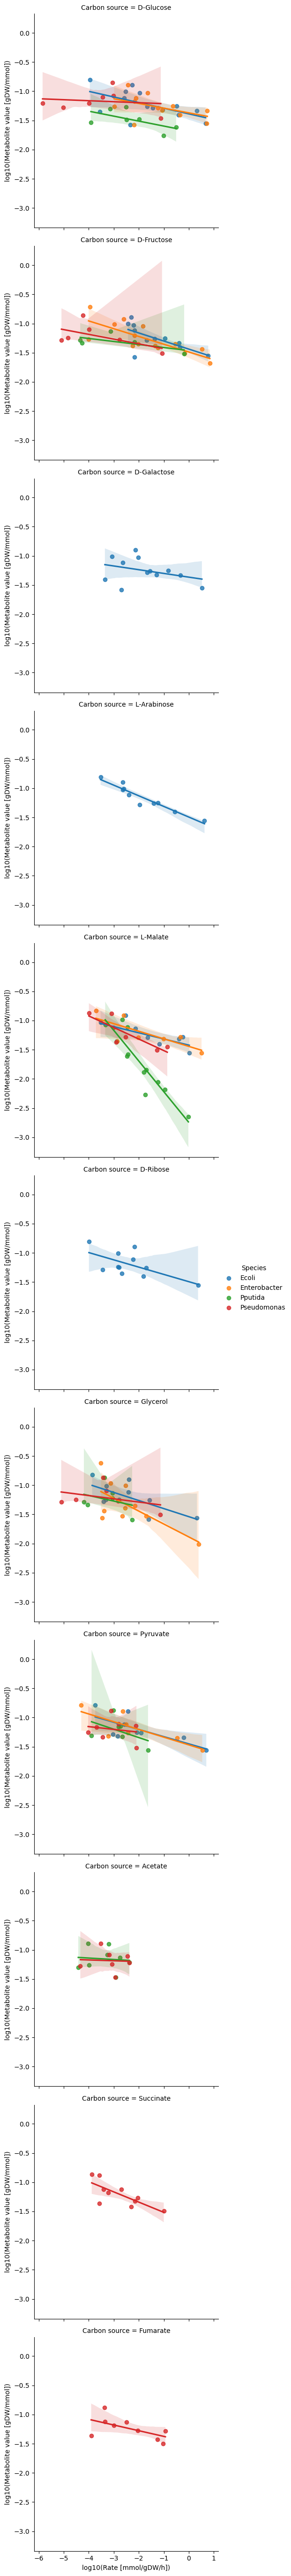

In [298]:
sns.lmplot(data = df_notnan, x = 'log10(Rate [mmol/gDW/h])',
           y = 'log10(Metabolite value [gDW/mmol])', hue = 'Species', col = 'Carbon source', col_wrap=1)


In [299]:
df.loc[df.isna().any(axis=1)]

Species Carbon source  Metabolite      Slope  Intercept        R2  \
0          Ecoli      L-Malate    Butyrate   2.182416  -0.003124  0.763953   
1          Ecoli    D-Fructose    Butyrate   1.050436   0.019042  0.619446   
2          Ecoli   D-Galactose    Butyrate   1.411775   0.049134  0.899492   
3          Ecoli      D-Ribose    Butyrate   3.110499   1.398223  0.579989   
4          Ecoli   L-Arabinose    Butyrate  10.284494   0.090859  0.905522   
..           ...           ...         ...        ...        ...       ...   
313  Pseudomonas      Glycerol    Valerate   0.180716   0.267373  0.536559   
314  Pseudomonas     Succinate    Valerate   0.805366  -0.000222  0.999995   
315  Pseudomonas      Fumarate    Valerate   1.252276   0.024128  0.986081   
317  Pseudomonas      L-Malate     Citrate  -0.721102   5.628970  0.257374   
324  Pseudomonas    D-Fructose  Putrescine  -0.015915   0.026538  0.263693   

      Std err  Peak time  Rate [mmol/gDW/h]  Std. Err [mmol/gDW/h]  \
0    0.700394  48.000000           0.002182               0.000700   
1    0.411667  34.666667           0.001050               0.000412   
2    0.333696  48.000000           0.001412               0.000334   
3    1.323489  48.000000           0.003110               0.001323   
4    2.349010  37.166667           0.010284               0.002349   
..        ...        ...                ...                    ...   
313  0.068566  48.000000           0.000181               0.000069   
314  0.001298  38.666667           0.000805               0.000001   
315  0.105205  34.000000           0.001252               0.000105   
317  0.866132  30.000000          -0.000721               0.000866   
324  0.026594  48.000000          -0.000016               0.000027   

    Metabolite ID  Turnover [mmol/gDW/h]  Metabolite value [gDW/mmol]  \
0             but               0.000000                          NaN   
1             but               0.000000                          NaN   
2             but               0.000000                          NaN   
3             but               0.000000                          NaN   
4             but               0.000000                          NaN   
..            ...                    ...                          ...   
313           pta               0.000000                          NaN   
314           pta               0.000000                          NaN   
315           pta               0.000000                          NaN   
317           cit               1.382562                     0.072721   
324          ptrc               0.004067                     0.102458   

     log10(Rate [mmol/gDW/h])  log10(Metabolite value [gDW/mmol])  \
0                   -2.661062                                 NaN   
1                   -2.978630                                 NaN   
2                   -2.850235                                 NaN   
3                   -2.507170                                 NaN   
4                   -1.987817                                 NaN   
..                        ...                                 ...   
313                 -3.743004                                 NaN   
314                 -3.094007                                 NaN   
315                 -2.902300                                 NaN   
317                       NaN                           -1.138340   
324                       NaN                           -0.989454   

     Mol weight [g/mol]  N carbons  Dataset  
0              87.09718        4.0  Vila-23  
1              87.09718        4.0  Vila-23  
2              87.09718        4.0  Vila-23  
3              87.09718        4.0  Vila-23  
4              87.09718        4.0  Vila-23  
..                  ...        ...      ...  
313           101.12376        5.0  Vila-23  
314           101.12376        5.0  Vila-23  
315           101.12376        5.0  Vila-23  
317           189.09970        6.0  Vila-23  
324            90.1

In [300]:
for strain in df_notnan.Species.unique():
    for cs in df_notnan['Carbon source'].unique():
        idx = (df_notnan.Species==strain) & (df_notnan['Carbon source']==cs)
        dfi = df_notnan.loc[idx]
        if not len(dfi):
            continue
        x = dfi['log10(Rate [mmol/gDW/h])']
        y = dfi['log10(Metabolite value [gDW/mmol])']
        print(strain, cs, st.pearsonr(x,y))

Ecoli D-Glucose PearsonRResult(statistic=np.float64(-0.5705504464824407), pvalue=np.float64(0.03311799446392887))
Ecoli D-Fructose PearsonRResult(statistic=np.float64(-0.654607842156633), pvalue=np.float64(0.028844098881847205))
Ecoli D-Galactose PearsonRResult(statistic=np.float64(-0.3472628976020821), pvalue=np.float64(0.2687394985534517))
Ecoli L-Arabinose PearsonRResult(statistic=np.float64(-0.951776934202191), pvalue=np.float64(2.2317276580567277e-05))
Ecoli L-Malate PearsonRResult(statistic=np.float64(-0.6746992145161946), pvalue=np.float64(0.046192973795128905))
Ecoli D-Ribose PearsonRResult(statistic=np.float64(-0.6319521325817524), pvalue=np.float64(0.036983956227194824))
Ecoli Glycerol PearsonRResult(statistic=np.float64(-0.6832710180286835), pvalue=np.float64(0.029402550416361597))
Ecoli Pyruvate PearsonRResult(statistic=np.float64(-0.7312440444766382), pvalue=np.float64(0.025177523330682548))
Enterobacter D-Glucose PearsonRResult(statistic=np.float64(-0.48852095471132384), 

In [301]:
dfi

Species Carbon source            Metabolite       Slope  Intercept  \
242  Pseudomonas      Fumarate   Alpha-ketoglutarate    1.010446  -0.000986   
252  Pseudomonas      Fumarate              Pyruvate   56.422081  14.306280   
258  Pseudomonas      Fumarate            Propionate    9.181146   0.227390   
265  Pseudomonas      Fumarate      Acetyl-ornithine    0.428065   0.005152   
272  Pseudomonas      Fumarate               Acetate   94.683269   0.264244   
281  Pseudomonas      Fumarate  Beta-hydroxybutyrate    0.452778   0.058154   
285  Pseudomonas      Fumarate                Serine    0.124495  -0.003633   
296  Pseudomonas      Fumarate             Succinate  115.916621   7.110083   
323  Pseudomonas      Fumarate               Citrate    3.272562   0.680236   

           R2    Std err  Peak time  Rate [mmol/gDW/h]  Std. Err [mmol/gDW/h]  \
242  0.999964   0.004301       34.0           0.001010               0.000004   
252  0.290296  62.380909       34.0           0.056422               0.062381   
258  0.977206   0.991510       34.0           0.009181               0.000992   
265  0.994523   0.022463       34.0           0.000428               0.000022   
272  0.999704   1.152206       34.0           0.094683               0.001152   
281  0.614523   0.253572       34.0           0.000453               0.000254   
285  0.968627   0.015843       34.0           0.000124               0.000016   
296  0.874840  31.002711       34.0           0.115917               0.031003   
323  0.378366   2.966091       34.0           0.003273               0.002966   

    Metabolite ID  Turnover [mmol/gDW/h]  Metabolite value [gDW/mmol]  \
242           akg               2.356250                     0.065257   
252           pyr               1.195493                     0.037168   
258           ppa               0.000000                     0.053236   
265         acorn               0.062682                     0.131775   
272            ac               0.095010                     0.031662   
281           bhb               0.343760                     0.075429   
285        ser__L               1.515410                     0.043136   
296          succ               0.090217                     0.051754   
323           cit               0.148999                     0.074834   

     log10(Rate [mmol/gDW/h])  log10(Metabolite value [gDW/mmol])  \
242                 -2.995487                           -1.185376   
252                 -1.248551                           -1.429831   
258                 -2.037103                           -1.273797   
265                 -3.368490                           -0.880166   
272                 -1.023727                           -1.499458   
281                 -3.344115                           -1.122459   
285                 -3.904848                           -1.365156   
296                 -0.935854                           -1.286055   
323                 -2.485112                           -1.125899   

     Mol weight [g/mol]  N carbons  Dataset  
242           144.08226        5.0  Vila-23  
252            87.05412        3.0  Vila-23  
258            73.07060        3.0  Vila-23  
265           174.19766        7.0  Vila-23  
272            59.04402        2.0  Vila-23  
281           103.09658        4.0  Vila-23  
285           105.09258        3.0  Vila-23  
296           116.07216        4.0  Vila-23  
323           189.09970        6.0  Vila-23